# Sepsis Model
A reproducibility study on an interpretable bi-lstm sepsis model with attention as proposed by a paper written by Dongdong Zhang, ChangChang Yin, Kathrin M Hunold, Xiaoqian Jiang, Jeffery M. Caterino and Ping Zhang in 2019.

Reference Paper:
https://doi.org/10.1016/j.patter.2020.100196

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import *
import time
import traceback
from glob import glob
from tqdm import tqdm
from sklearn import metrics
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

### Data Reformatting
Goal: reformat data to consumable chunks (master, labels, and vitals) to reduce training time on the model. All patient encounters were included in training set. Vitals taken on patients after they crossed the 6-hour threshold (prediction time) were omitted.

Data overview (two training sets):
*   40,367 patient encounters
*   1,525,203 recorded hourly vitals

Processing time:
*   7.6 hours to reformat data


In [ ]:
def reformatData(file_location, appendX='', use_exisiting=False):
  # file_location = '/content/drive/MyDrive/sepsismodel/training_setA/'
  ind = 0
  hrs_b4 = 6

  # exisiting flag was used to create the ability to resume reformatting within an 
  #     environment that has and idle timesout such as google colab
  if not use_exisiting:
    master_file = pd.DataFrame([],columns=[
        'adm_id','Gender','Age','Unit1','Unit2'])
    label_file = pd.DataFrame([],columns=['adm_id','SepsisLabel'])
    vitals_file = pd.DataFrame([],columns=['adm_id','HR','O2Sat','Temp','SBP','MAP',
    'DBP','Resp','EtCO2','BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2',
    'AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine',
    'Bilirubin_direct','Glucose','Lactate','Magnesium','Phosphate',
    'Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC',
    'Fibrinogen','Platelets','ICULOS'])
  if use_exisiting:
    master_file=pd.read_csv(f'/content/drive/MyDrive/sepsismodel_ctr/master{appendX}.csv')
    label_file=pd.read_csv(f'/content/drive/MyDrive/sepsismodel_ctr/label{appendX}.csv')
    vitals_file=pd.read_csv(f'/content/drive/MyDrive/sepsismodel_ctr/vital{appendX}.csv')

  for f in os.listdir(file_location):
    if '.psv' not in f: #avoid non-data files
      continue

    if ind%100==0: #monitor progress
      print(ind)

    if f.replace('.psv','') in list(master_file.adm_id) and \
    f.replace('.psv','') in list(label_file.adm_id) and \
    f.replace('.psv','') in list(vitals_file.adm_id): #skip if already exists
      ind+=1
      continue

    if ind%1000==0 and ind>=0: #save progress every 1000 patient encounters
      master_file.to_csv(f'/content/drive/MyDrive/sepsismodel_ctr/master{appendX}.csv'
      ,index=False)
      label_file.to_csv(f'/content/drive/MyDrive/sepsismodel_ctr/label{appendX}.csv'
      ,index=False)
      vitals_file.to_csv(f'/content/drive/MyDrive/sepsismodel_ctr/vital{appendX}.csv'
      ,index=False)

    data = pd.read_csv(file_location+f,sep='|')

    #Append to master file
    master = data.loc[:,['Gender','Age','Unit1','Unit2','HospAdmTime']]
    if f.replace('.psv','') in list(master_file.adm_id):
      pass
    else:
      master.loc[:,['adm_id']] = f.replace('.psv','')
      master_file = pd.concat([master_file,master.drop_duplicates()],axis=0)

    #Append to label file
    label = data.loc[:,['SepsisLabel']]
    if f.replace('.psv','') in list(label_file.adm_id):
      pass
    else:
      label.loc[:,['adm_id']] = f.replace('.psv','')
      label = label.groupby(by='adm_id').max().reset_index()
      label_file = pd.concat([label_file,label],axis=0)

    #Append to vitals file, only those 6 hours advance of sepsis
    vitals = data.drop(
        columns=['Gender','Age','Unit1','Unit2','HospAdmTime'])
    if f.replace('.psv','') in list(vitals_file.adm_id):
      pass
    else:
      vitals.loc[:,['adm_id']] = f.replace('.psv','')
      vitals = vitals.loc[(vitals.SepsisLabel==0),:]
      vitals = vitals.drop(columns=['SepsisLabel'])
      vitals_file = pd.concat([vitals_file,vitals],axis=0)
    
    ind+=1
    del data
  #Save final files
  master_file.to_csv(f'/content/drive/MyDrive/sepsismodel_ctr/master{appendX}.csv',index=False)
  label_file.to_csv(f'/content/drive/MyDrive/sepsismodel_ctr/label{appendX}.csv',index=False)
  vitals_file.to_csv(f'/content/drive/MyDrive/sepsismodel_ctr/vital{appendX}.csv',index=False)
  return

def main_preprocess():
  reformatData('/content/drive/MyDrive/sepsismodel/training_setA/','A',True)
  reformatData('/content/drive/MyDrive/sepsismodel/training_setB/','B')

main_preprocess()

### Visualizing Data
Visualized and evaluated elements:
1.   Master
  * Age: age distribution was evaluated via a histogram and the resulting age groups were determined to keep groups at a comparable size, with the exception of adolescents who were kept separate, though small in number, due to increased baseline vitals.
  * Gender: gender distribution was approximately equal, with a slightly skew towards Male (Gender=1), particularly in training set A. No action taken.
  * Hospital Unit: Value only available for a little over half of combined A and B training sets. Additionally, this would not be a generalizable feature for other hospitals. This feature will be left out of the final training data.
  * Admission Time: The large majority of the hours between hospital admit and admission to the ICU are negative, likely these values are flipped (i.e. time from ICU to hospital admsision). Will continue with data being largely negative as a negative weight could resolve this issue without making assumptions about the data. There appear to be large outliers with the time between the two admission being greater than 480  hours (20 days), these outliers will be stripped from both datasets resulting in a less than 2% reduction.


2.   Label
  * Very large skew towards non-septic patients. Sepsis prevalence in the A and B datasets are 9% and 6%, respectively. This prevalence is representative of a real-world scenario in a hospital, therefore no sampling techniques will be used initially.

3.   Vitals
  * All vitals were evaluated via an initial histogram for distribution. 
  * Vitals with approximately normal distributions with a relatively close mean and median include: Heart Rate (HR), Oxygen Saturation (O2Sat), Temperature (Temp), Systolic Blood Pressure (SBP), Mean Arterial Pressure (MAP), Diastolic Blood Pressure (DBP), Respiratory Rate (Resp), End tidal carbon dioxide (EtCO2), Excess bicarbonate (BaseExcess), Fraction of inspired oxygen (FiO2), pH, Partial pressure of carbon dioxide from arterial blood (PaCO2), Calcium, Chloride, Magnesium, Phosphate, Potassium, Hematocrit (Hct), and Hemoglobin (Hgb).
  * Vitals that were skewed included Oxygen saturation from arterial blood (SaO2) with a left skew and Aspartate transaminase (AST), Alkaline phosphatase (Alkalinephos), BUN, Creatinine, Bilirubin direcct, Glucose, Lactate, Bilirubin total,Troponin I, Partial thromboplastin time (PTT), Leukocyte count(WBC), Fibrinogen, and Platlets with a right skew. Glucose, Lactate, WBC, Fibrinogren and Platlets were very slightly skewed.



In [ ]:
#Load Data
master_fileA=pd.read_csv('/content/drive/MyDrive/sepsismodel_ctr/masterA.csv')
master_fileB=pd.read_csv('/content/drive/MyDrive/sepsismodel_ctr/masterB.csv')
label_fileA=pd.read_csv('/content/drive/MyDrive/sepsismodel_ctr/labelA.csv')
label_fileB=pd.read_csv('/content/drive/MyDrive/sepsismodel_ctr/labelB.csv')
vitals_fileA=pd.read_csv('/content/drive/MyDrive/sepsismodel_ctr/vitalA.csv')
vitals_fileB=pd.read_csv('/content/drive/MyDrive/sepsismodel_ctr/vitalB.csv')

#### Master - Age

<Axes: >

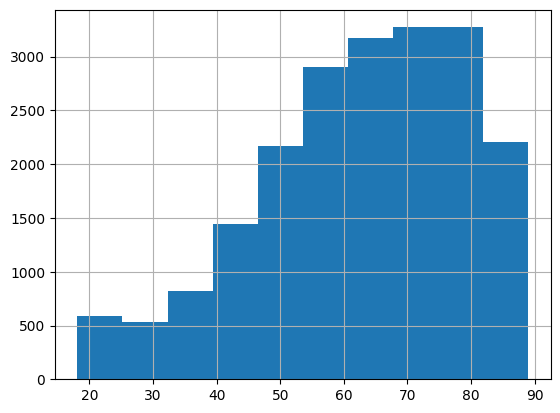

In [ ]:
master_fileA.Age.hist()

<Axes: >

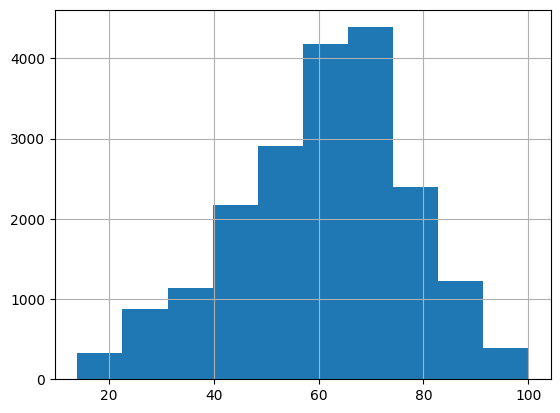

In [ ]:
master_fileB.Age.hist()

In [ ]:
def setAgeGroup(age):
  if int(age) < 18:
    return '0-17'
  elif int(age) < 35:
    return '18-34'
  elif int(age) < 50:
    return '35-49'
  elif int(age) < 60:
    return '50-59'
  elif int(age) < 70:
    return '60-69'
  elif int(age) < 80:
    return '70-79'
  else:
    return '80+'

In [ ]:
master_fileA.Age.apply(lambda x: setAgeGroup(x)).value_counts()

70-79    4622
60-69    4554
50-59    3776
80+      3045
35-49    2982
18-34    1386
Name: Age, dtype: int64

In [ ]:
master_fileB.Age.apply(lambda x: setAgeGroup(x)).value_counts()

60-69    4985
70-79    3954
50-59    3921
35-49    3227
80+      2322
18-34    1569
0-17       22
Name: Age, dtype: int64

#### Master - Gender

<Axes: >

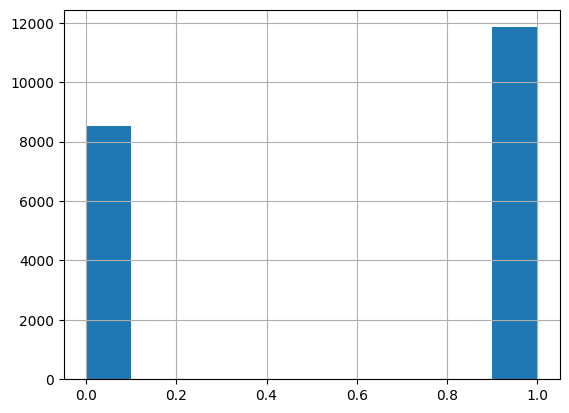

In [ ]:
master_fileA.Gender.hist()

<Axes: >

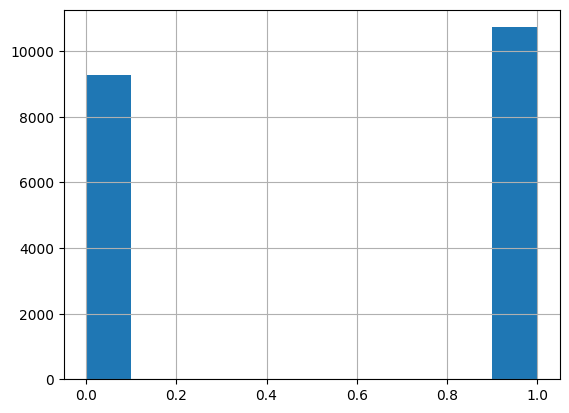

In [ ]:
master_fileB.Gender.hist()

#### Master - Hospital Unit

In [ ]:
print(master_fileA.Unit1.value_counts(),
      master_fileA.Unit2.value_counts(),
      master_fileB.Unit1.value_counts(),
      master_fileB.Unit2.value_counts())

0.0    5478
1.0    5355
Name: Unit1, dtype: int64 1.0    5478
0.0    5355
Name: Unit2, dtype: int64 0.0    6982
1.0    6923
Name: Unit1, dtype: int64 1.0    6982
0.0    6923
Name: Unit2, dtype: int64


#### Master - Time from Hospital Admission to ICU Admission

In [ ]:
print(master_fileA.HospAdmTime.min(),
      master_fileA.HospAdmTime.max())
print(master_fileB.HospAdmTime.min(),
      master_fileB.HospAdmTime.max())

-3710.66 23.99
-5366.86 0.0


<Axes: >

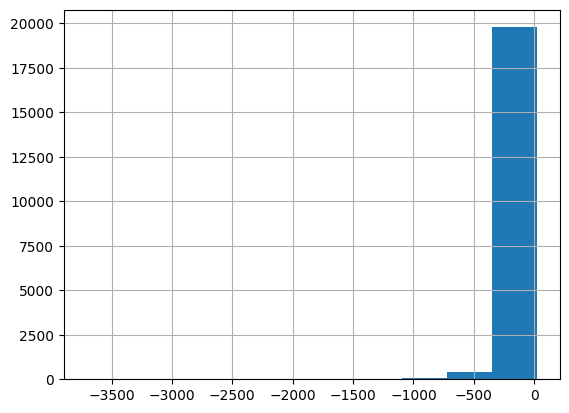

In [ ]:
master_fileA.HospAdmTime.hist()

<Axes: >

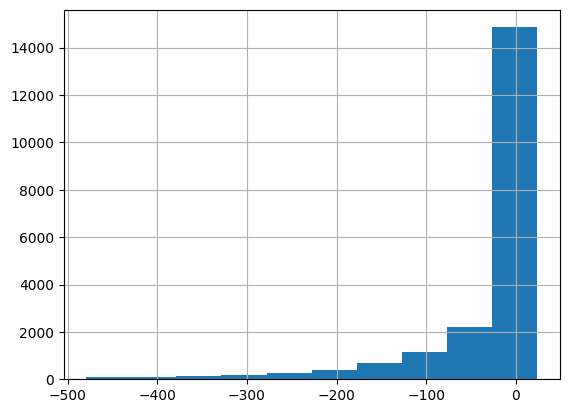

In [ ]:
master_fileA.loc[(master_fileA.HospAdmTime>=-480)].HospAdmTime.hist()

In [ ]:
len(master_fileA.loc[(master_fileA.HospAdmTime>=-480)])/len(master_fileA)

0.9834028971274245

<Axes: >

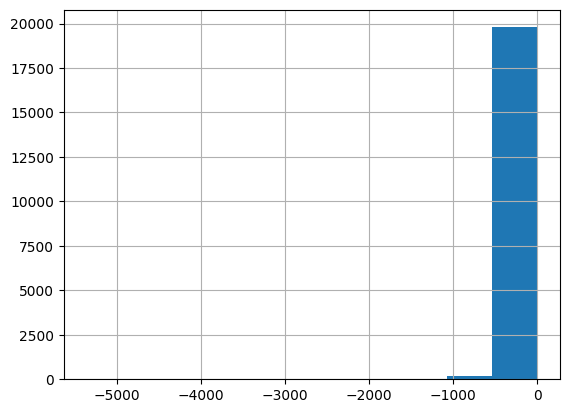

In [ ]:
master_fileB.HospAdmTime.hist()

<Axes: >

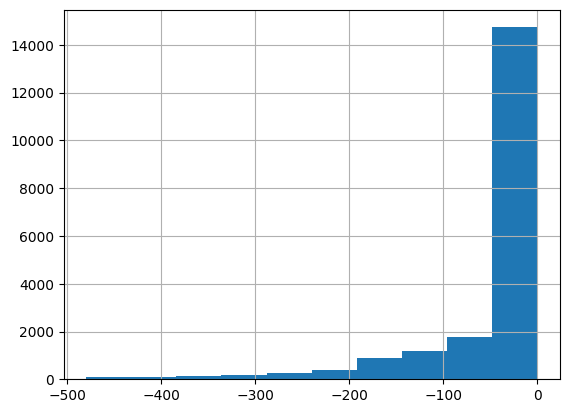

In [ ]:
master_fileB.loc[(master_fileB.HospAdmTime>=-480)].HospAdmTime.hist()

In [ ]:
len(master_fileB.loc[(master_fileB.HospAdmTime>=-480)])/len(master_fileB)

0.9863

#### Label - SepsisLabel

<Axes: >

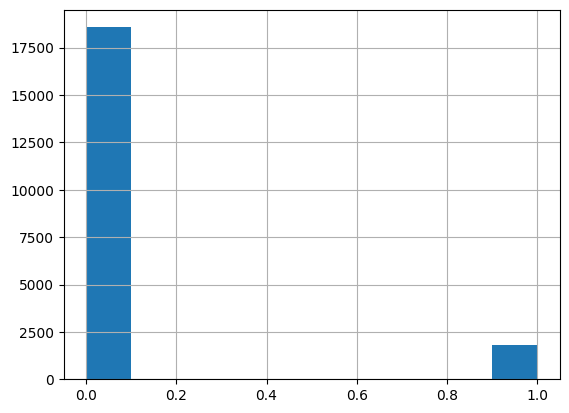

In [ ]:
label_fileA.SepsisLabel.hist()

In [ ]:
label_fileA.SepsisLabel.sum()/label_fileA.SepsisLabel.count()

0.08804321139209428

<Axes: >

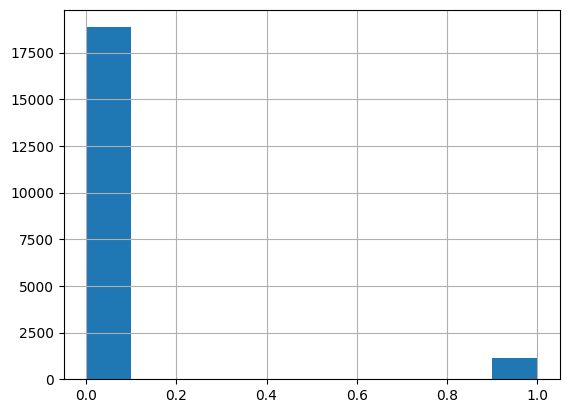

In [ ]:
label_fileB.SepsisLabel.hist()

In [ ]:
label_fileB.SepsisLabel.sum()/label_fileB.SepsisLabel.count()

0.0571

#### Master/Label removal if no matching vitals

In [ ]:
def removeMissing(vits, mast, labl):
  vit_ids = pd.DataFrame(vits.adm_id.unique(),columns=['adm_id'])
  mast_short = mast.merge(right=vit_ids,left_on='adm_id',right_on='adm_id')
  labl_short = labl.merge(right=vit_ids,left_on='adm_id',right_on='adm_id')
  return mast_short, labl_short

#### Vitals

HR 

84.87404326076512 84.0


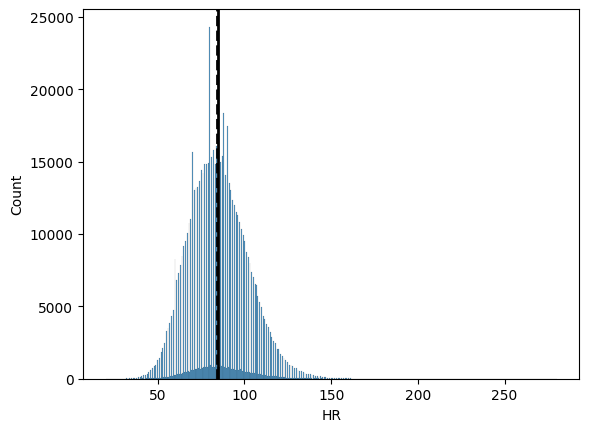

O2Sat 

97.26943752452591 98.0


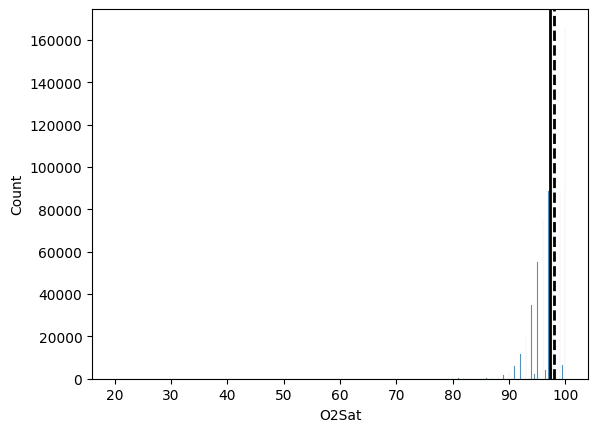

Temp 

37.022079783616924 37.06


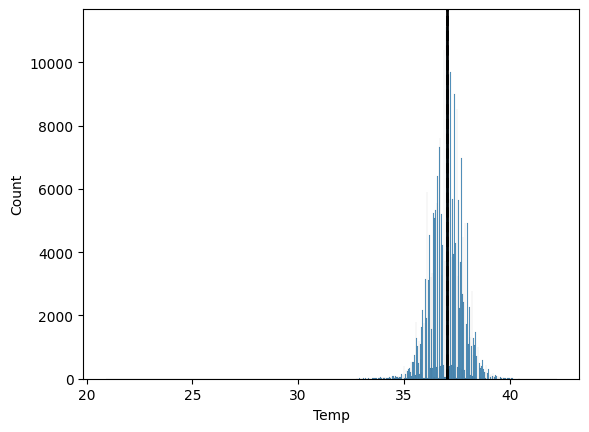

SBP 

120.97249175759329 118.5


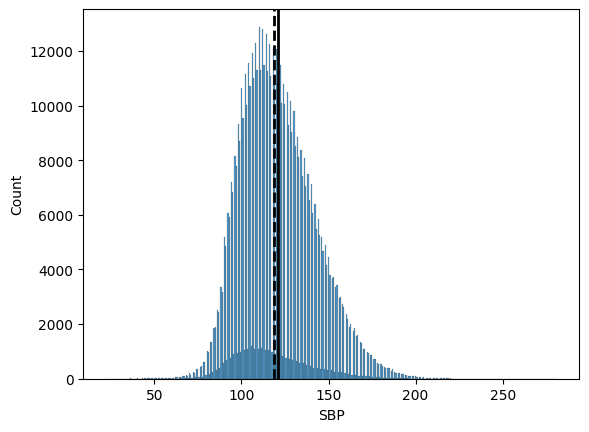

MAP 

78.7767859776047 77.0


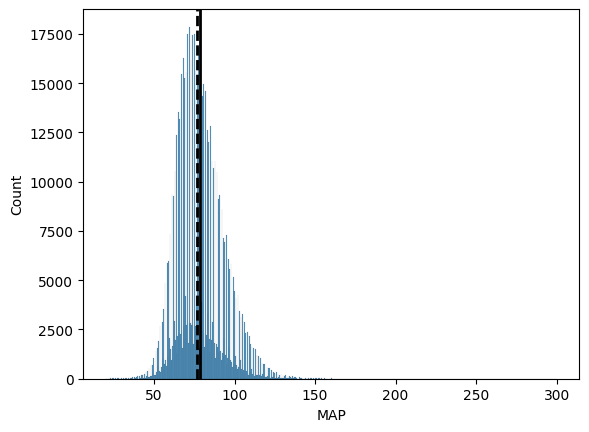

DBP 

59.974964399920054 58.5


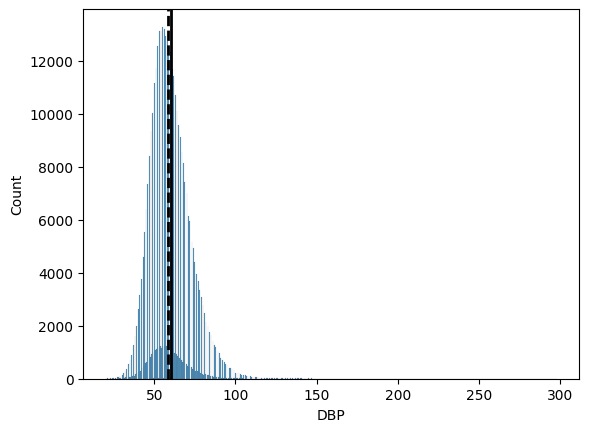

Resp 

18.728557652358045 18.0


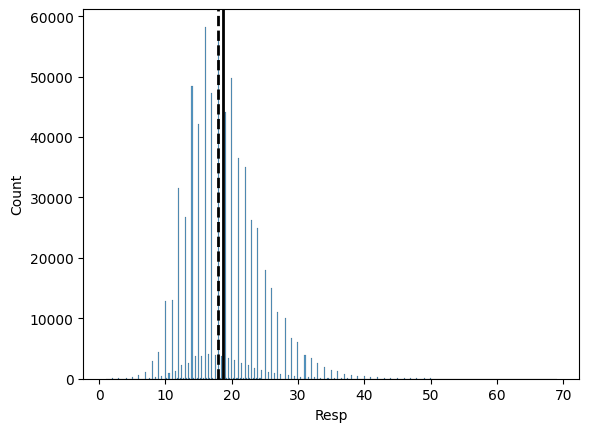

EtCO2 



/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


nan nan


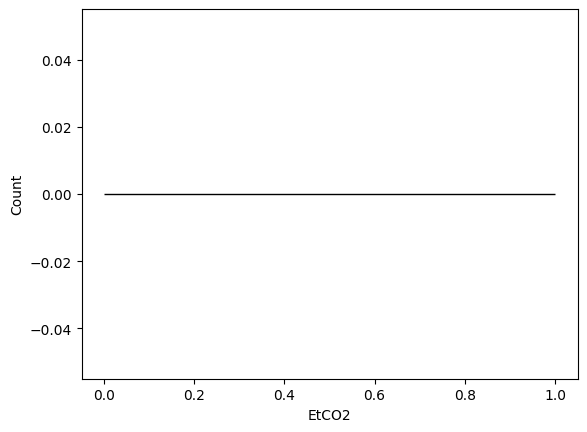

BaseExcess 

-0.6622225705329153 0.0


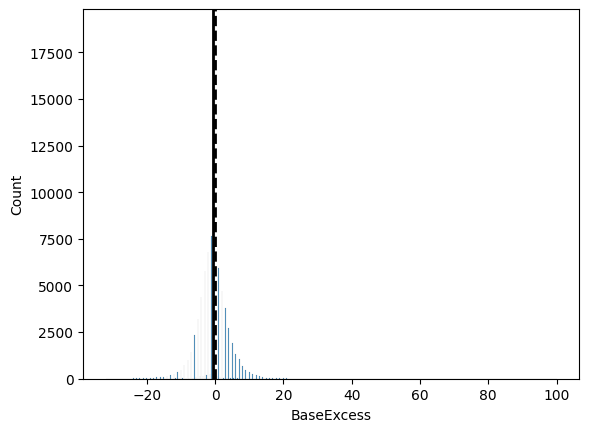

HCO3 

24.1033367175917 24.0


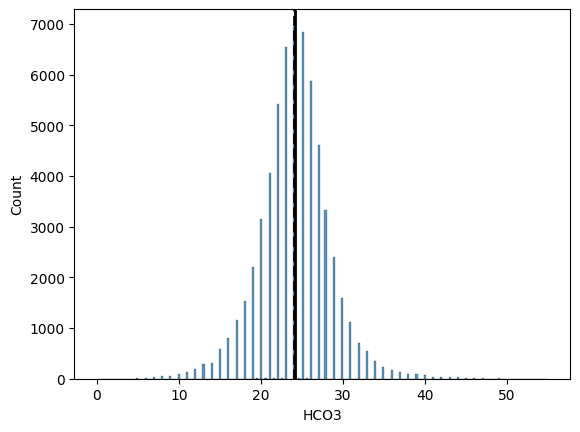

FiO2 

0.5255965804066544 0.5


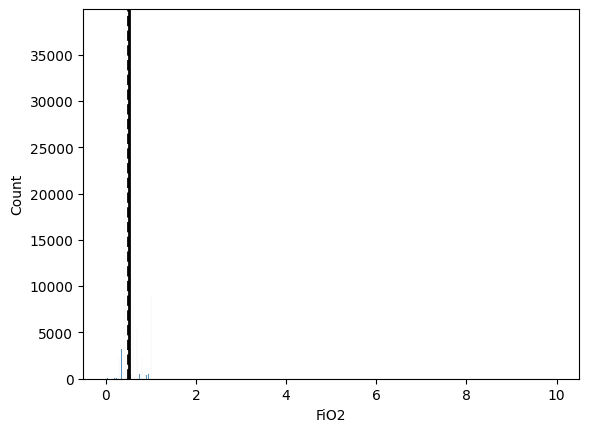

pH 

7.380237269242582 7.39


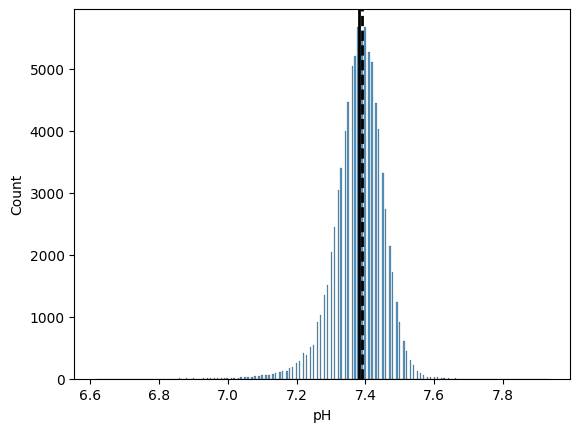

PaCO2 

41.1308054260911 40.0


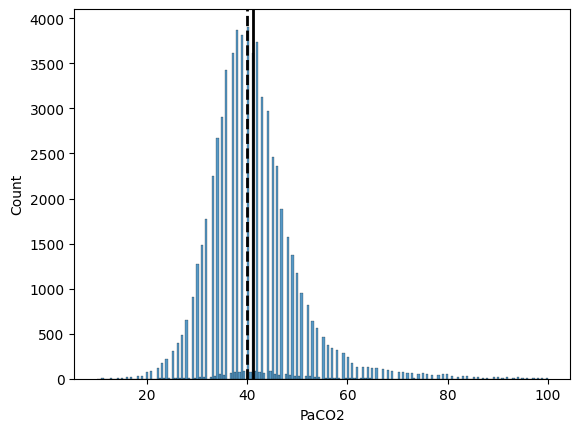

SaO2 

91.21834109703758 97.0


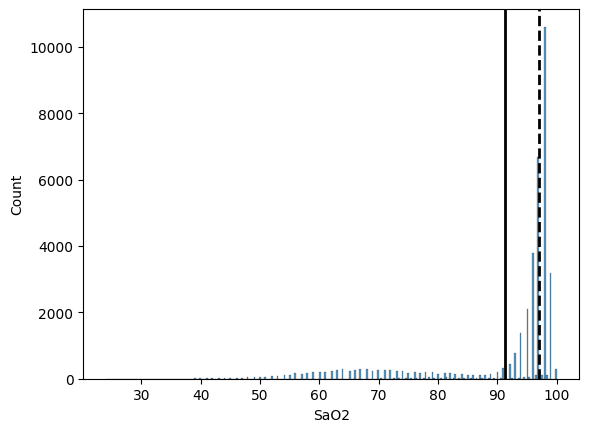

AST 

357.0037858777954 56.0


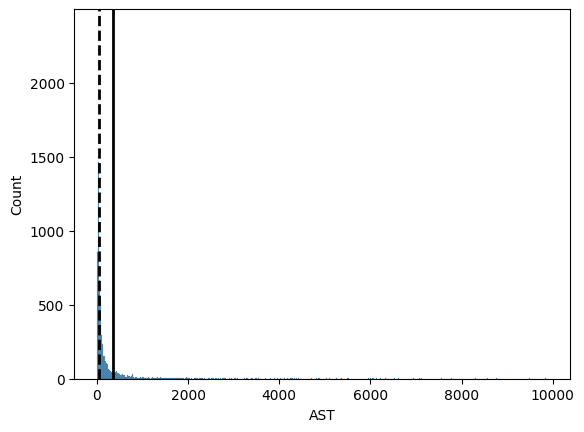

BUN 

24.181708926158493 18.0


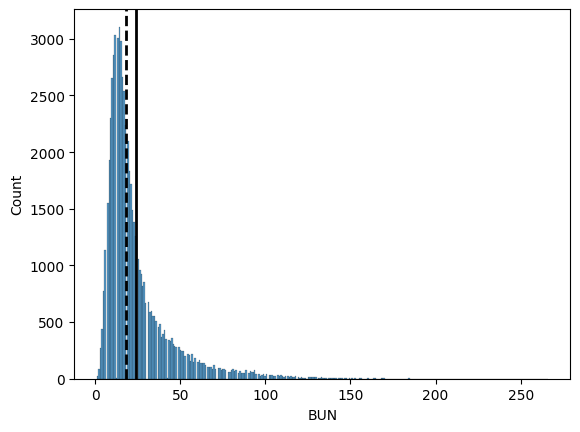

Alkalinephos 

113.82066443983028 78.0


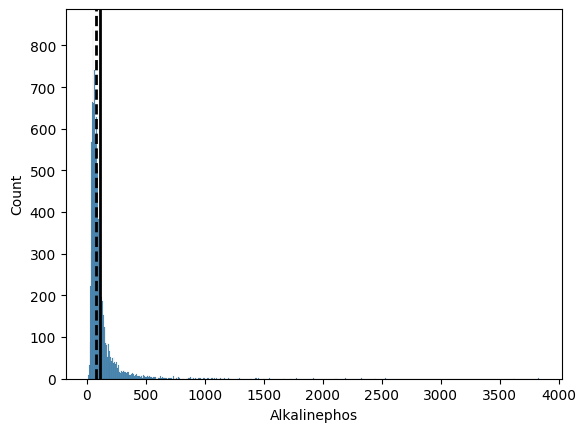

Calcium 

8.318715200627368 8.3


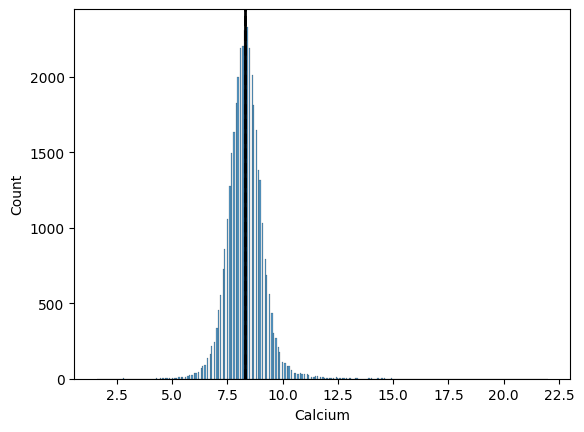

Chloride 

105.77380581435204 106.0


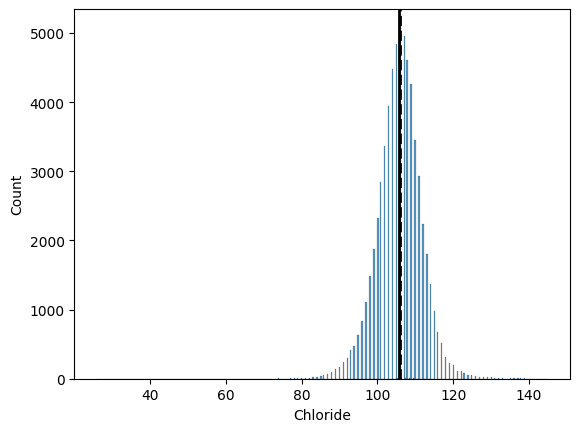

Creatinine 

1.3961802508142684 0.9


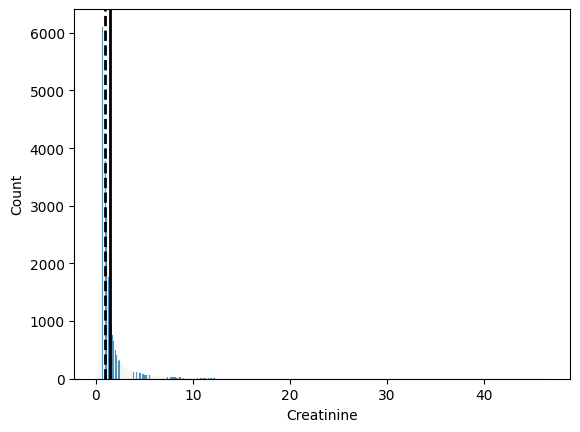

Bilirubin_direct 

3.057330992098332 1.3


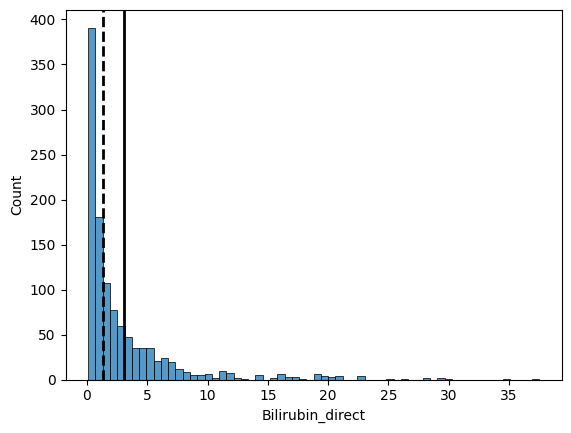

Glucose 

133.54562361413215 124.0


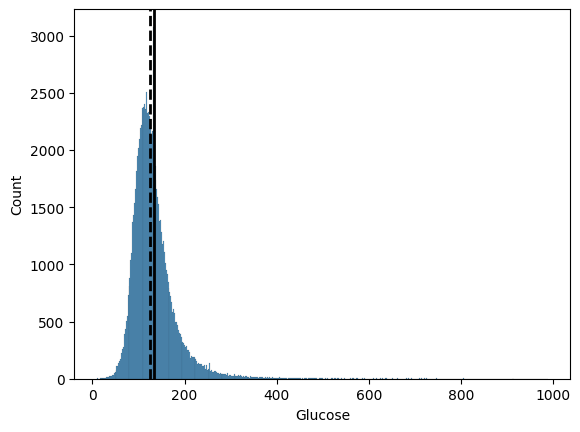

Lactate 

2.4704458402373706 1.8


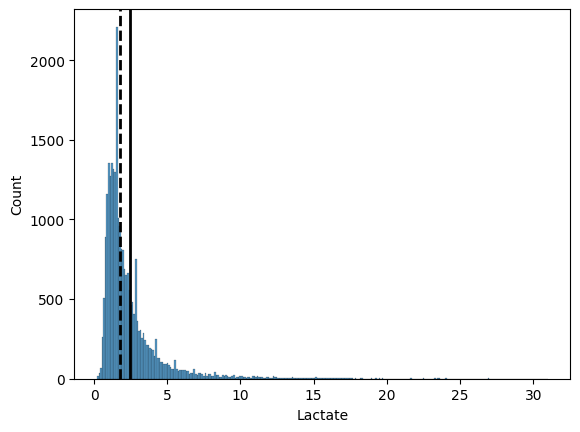

Magnesium 

2.040700333889817 2.0


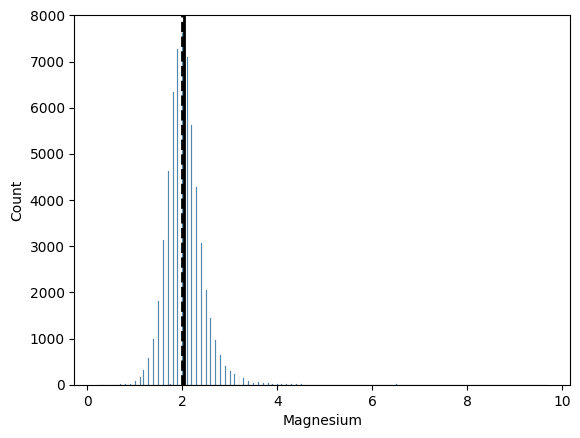

Phosphate 

3.5844938176197827 3.4


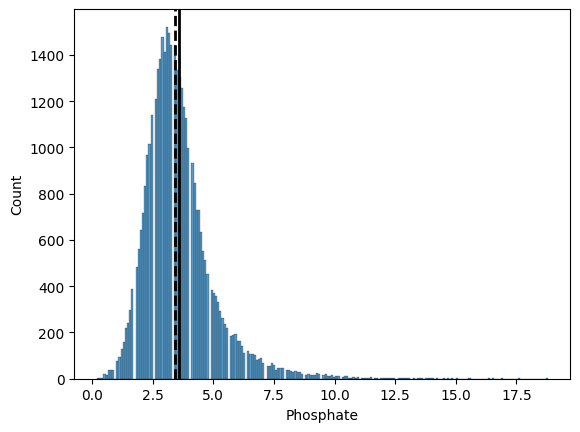

Potassium 

4.161661715049336 4.1


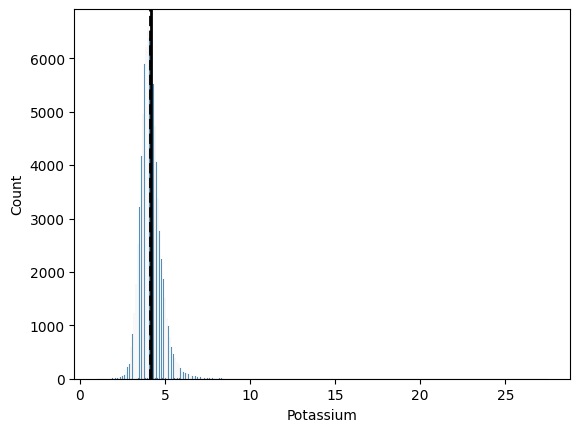

Bilirubin_total 

2.6390477720651235 0.9


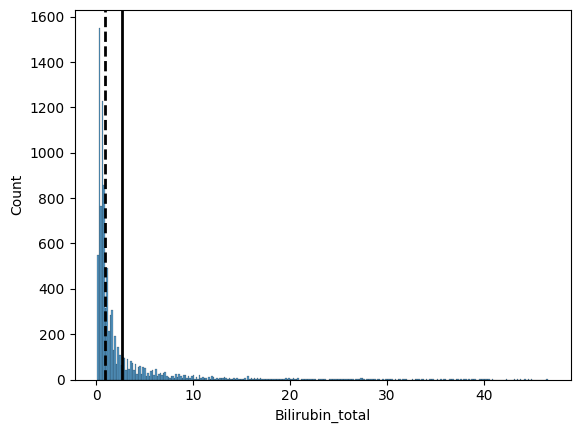

TroponinI 

9.35015706806283 4.4


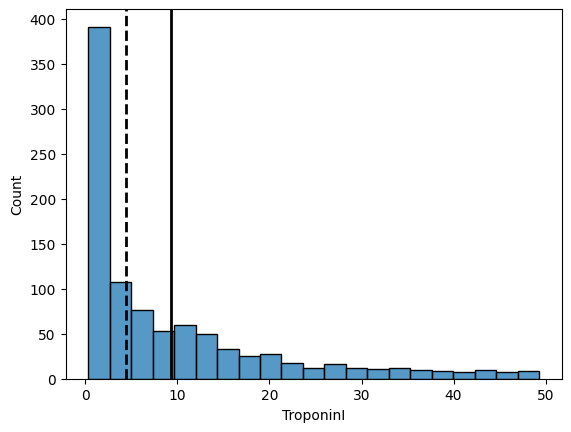

Hct 

30.683740266871666 30.2


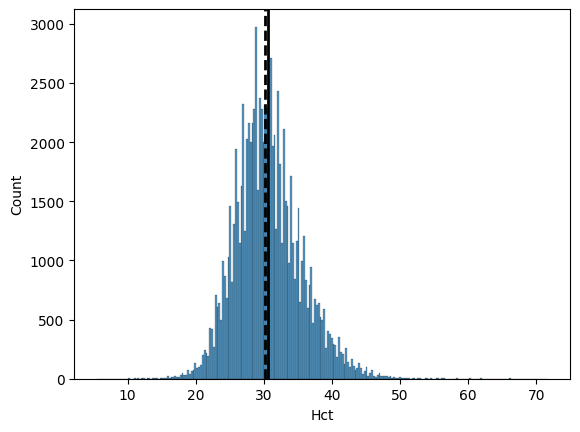

Hgb 

10.587713996508576 10.4


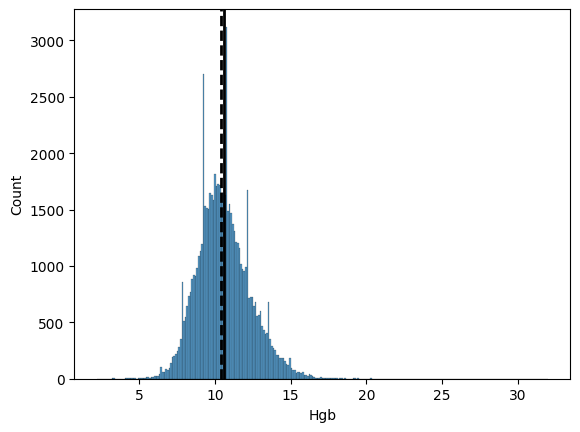

PTT 

40.68878558992902 32.3


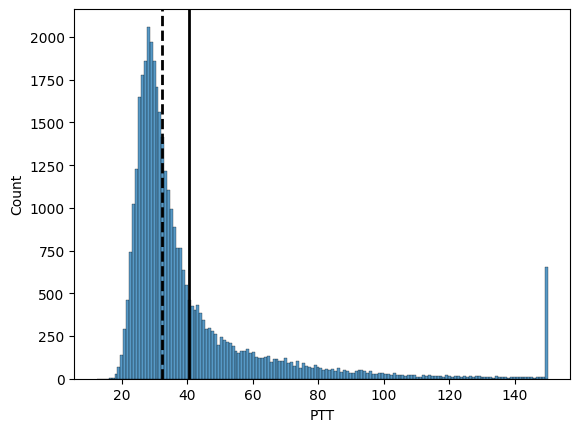

WBC 

11.909019174677685 10.8


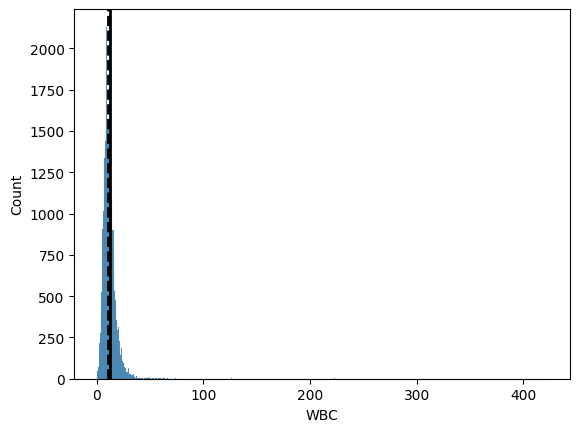

Fibrinogen 

290.55270037839693 249.0


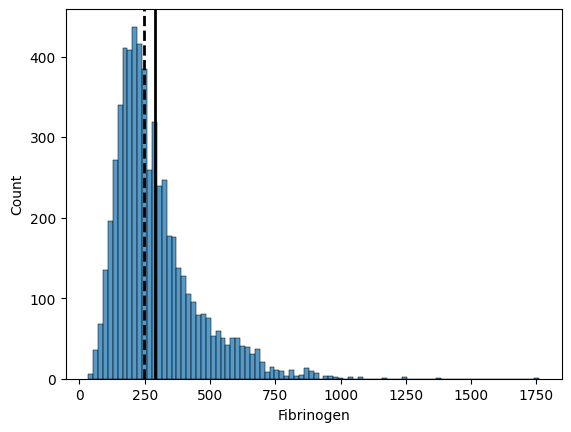

Platelets 

199.77236193881603 181.0


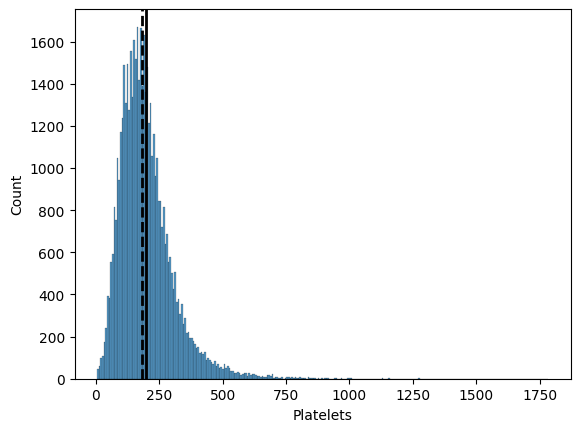

In [ ]:
for v in vitals_fileA.iloc[:,1:-1].columns:
  print(v,'\n')
  x = vitals_fileA[v]
  ax = sns.histplot(x)
  ax.axvline(x.mean(), color='k', lw=2)
  ax.axvline(x.median(), color='k', ls='--', lw=2)
  print(x.mean(),x.median())
  plt.show()

HR 

84.03397806752439 83.0


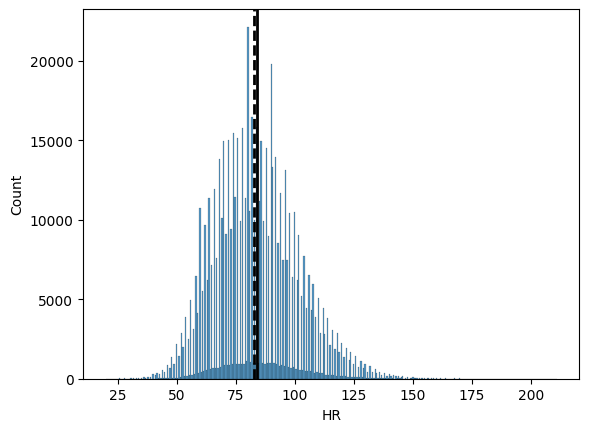

O2Sat 

97.12254000353587 98.0


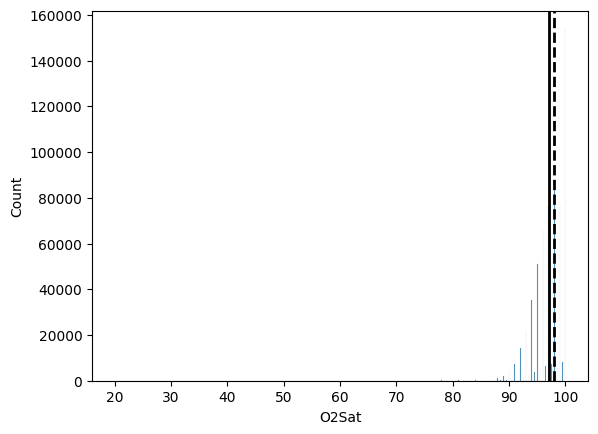

Temp 

36.920978264716645 36.9


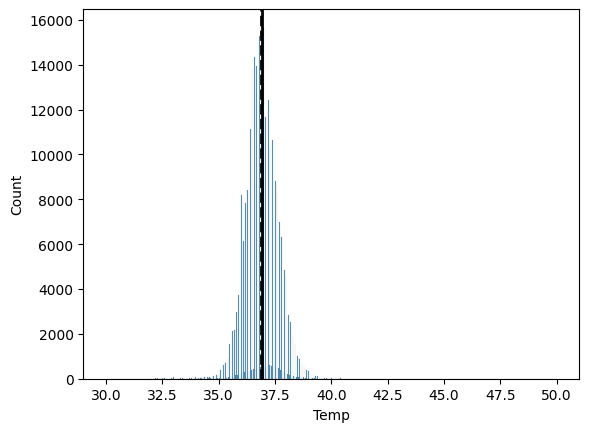

SBP 

126.64752619951551 124.0


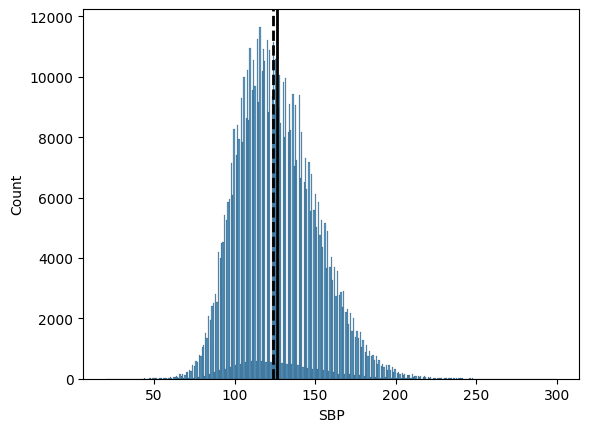

MAP 

86.4117686576375 84.0


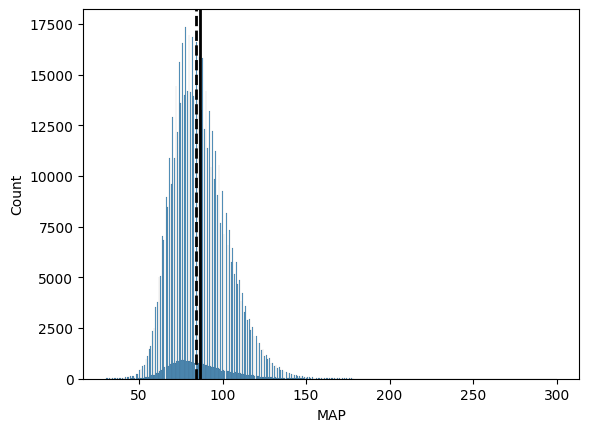

DBP 

66.27393275136606 65.0


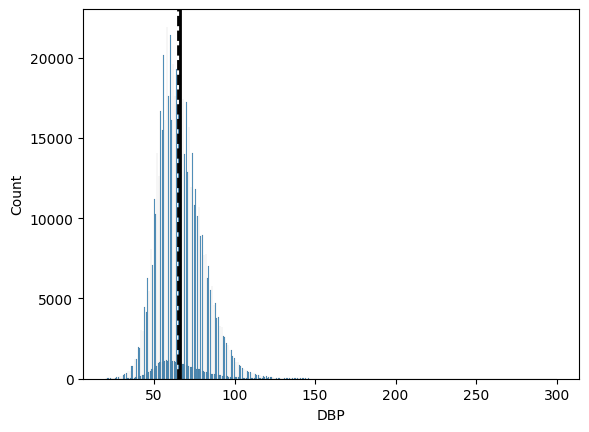

Resp 

18.654056301724342 18.0


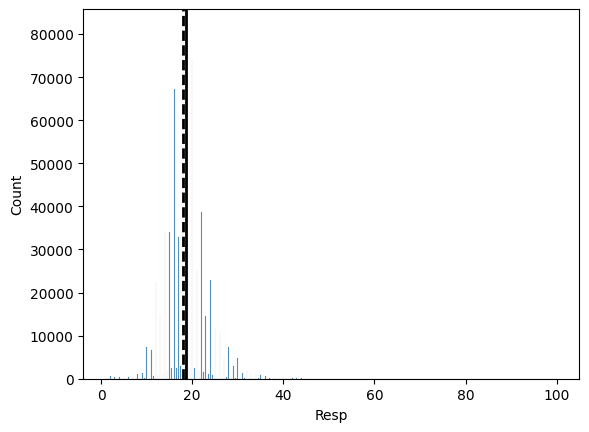

EtCO2 

32.98636505060488 33.0


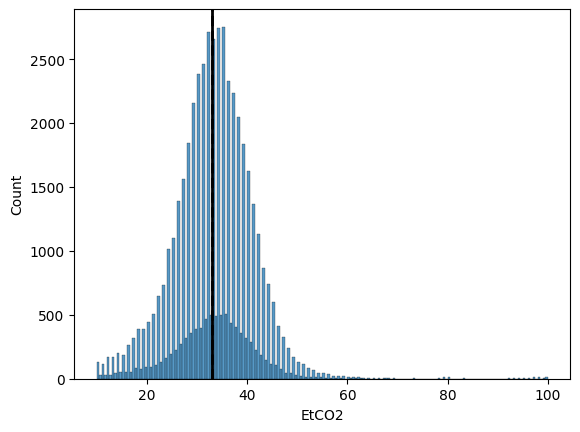

BaseExcess 

-2.6184421182266004 -2.4


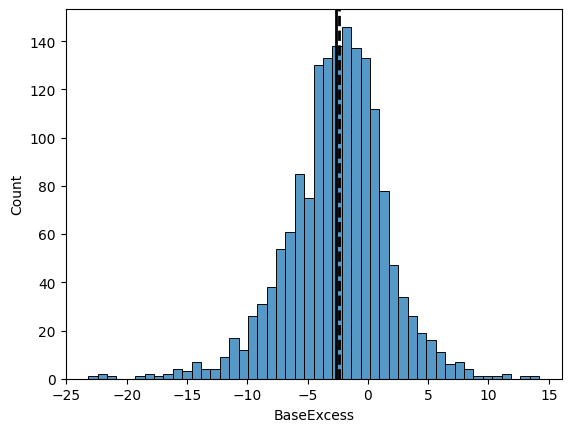

HCO3 

23.20601051840721 23.45


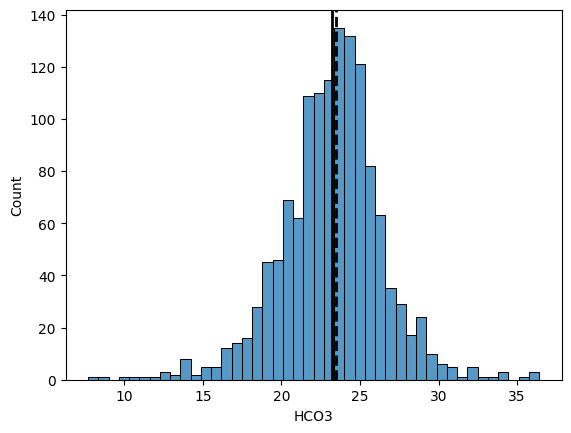

FiO2 

0.7495623847572219 0.4


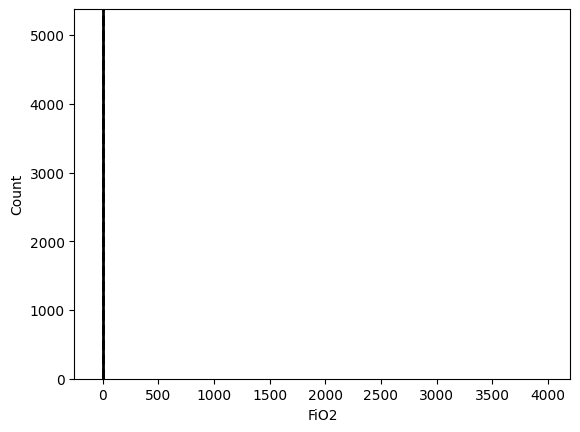

pH 

7.372241917363623 7.38


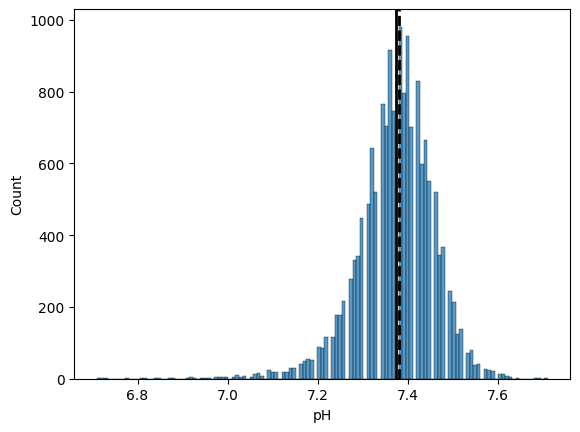

PaCO2 

40.42802813394747 39.0


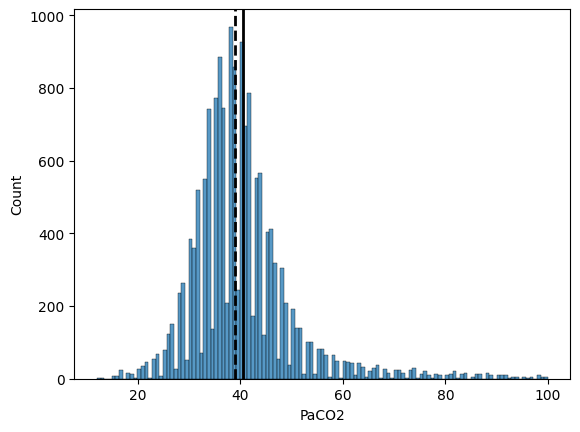

SaO2 

96.63291936910379 97.5


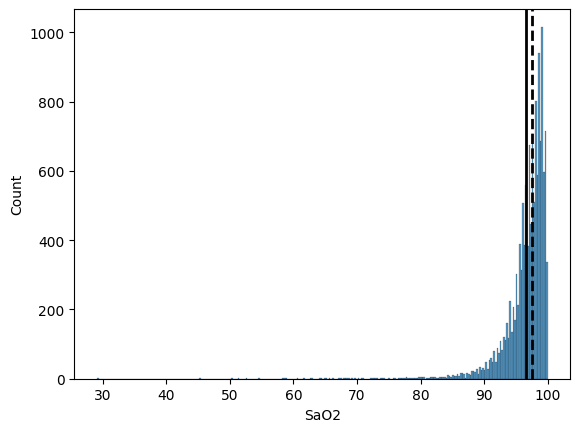

AST 

172.53859527121003 32.0


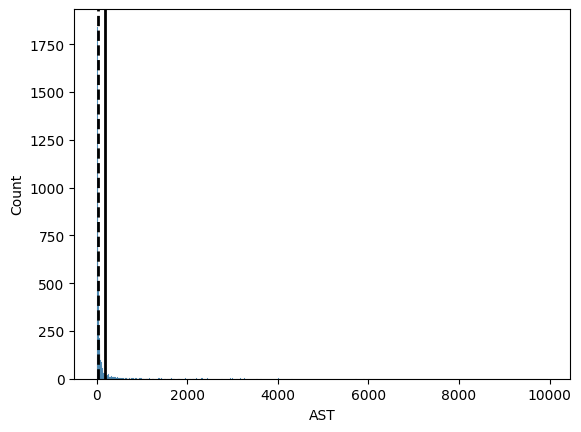

BUN 

23.069549921145214 17.0


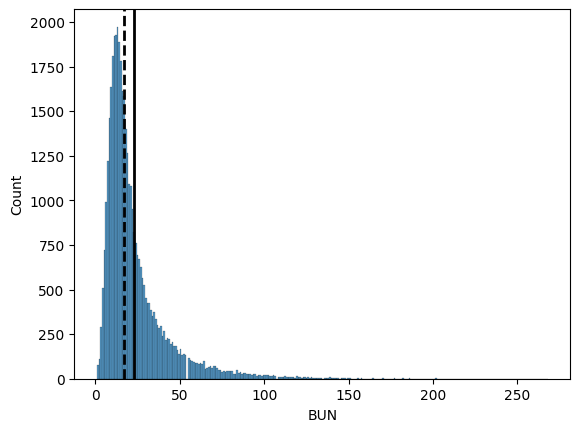

Alkalinephos 

92.22337312283403 70.0


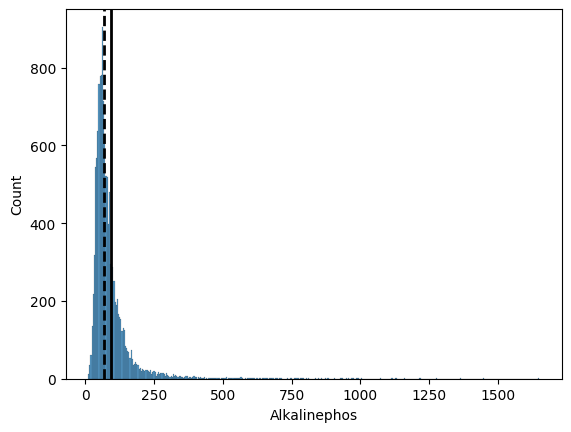

Calcium 

7.012293268662012 8.2


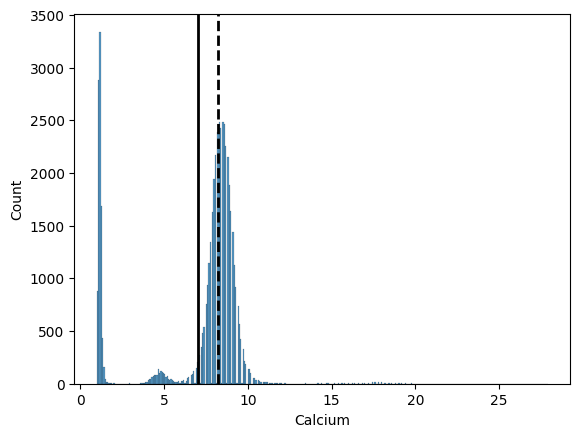

Chloride 

106.75112359550562 107.0


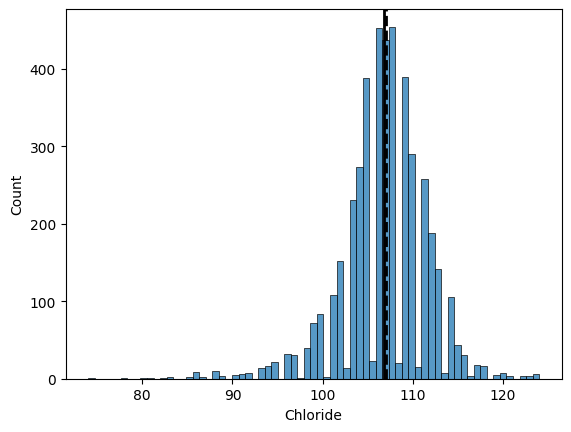

Creatinine 

1.6342014932609326 0.98


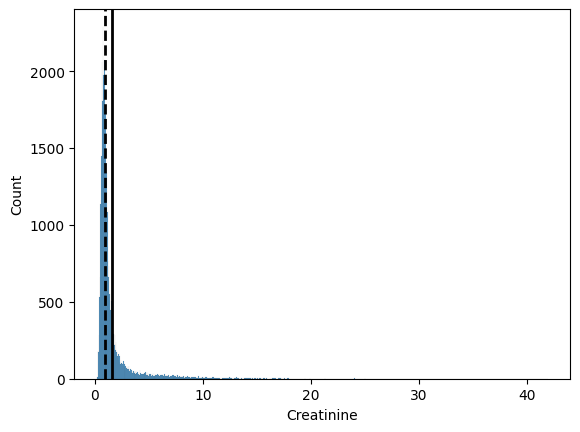

Bilirubin_direct 

0.9506790481717934 0.2


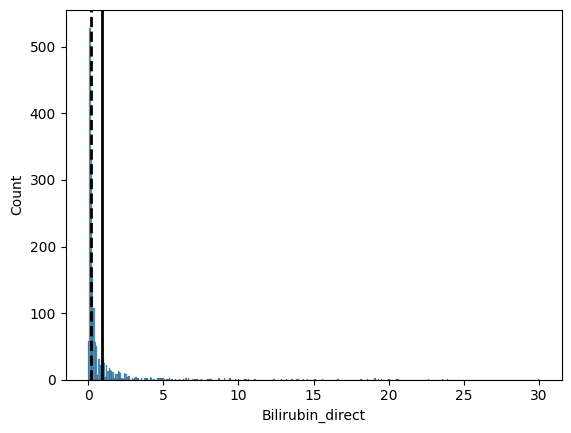

Glucose 

138.76647339761567 128.0


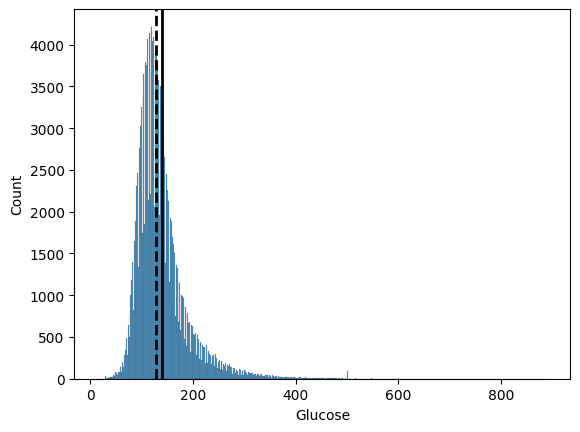

Lactate 

2.971254332276382 1.98


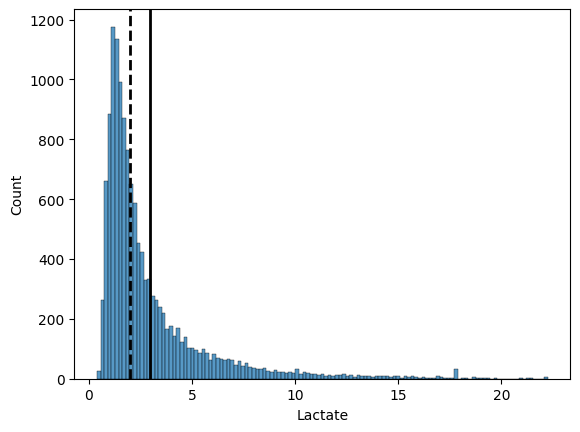

Magnesium 

2.0683636058324706 2.0


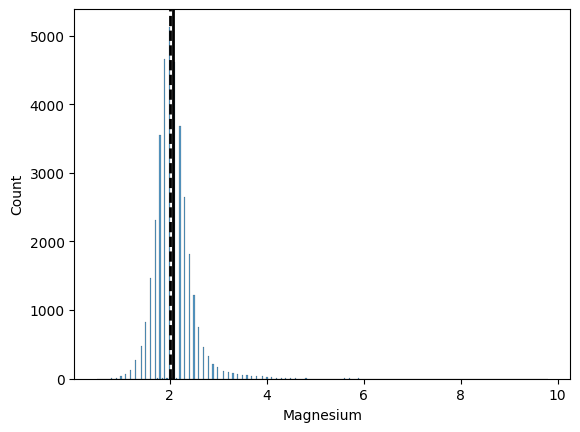

Phosphate 

3.4590516650678365 3.3


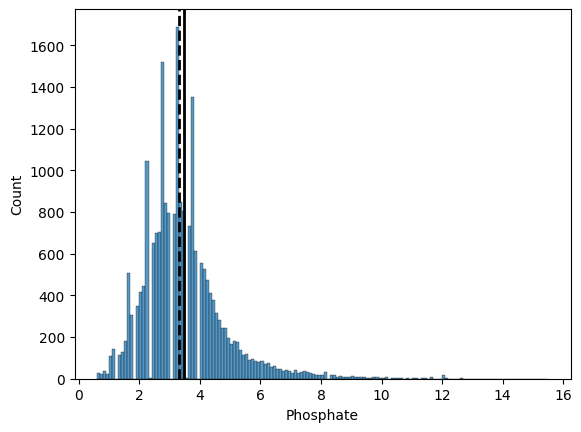

Potassium 

4.09549670148914 4.0


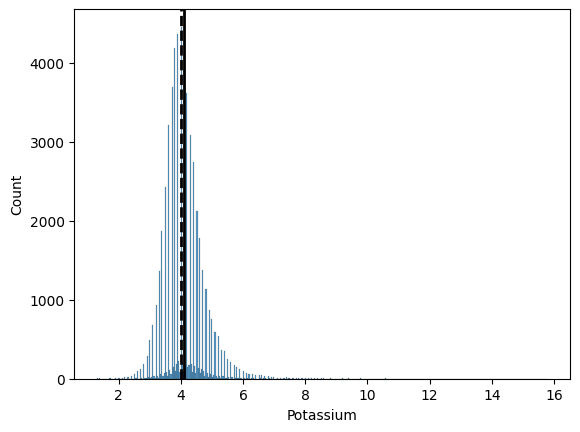

Bilirubin_total 

1.6685483870967739 0.8


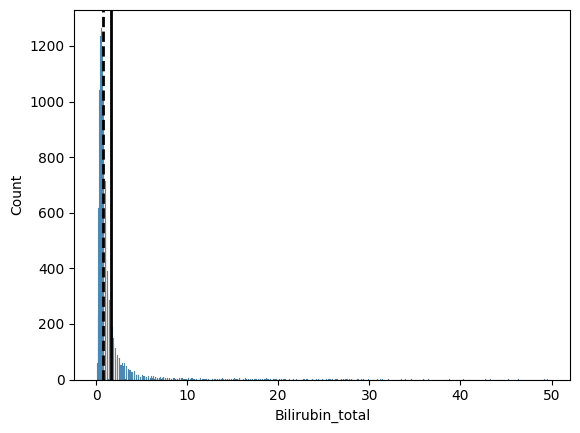

TroponinI 

8.185417530352384 0.22


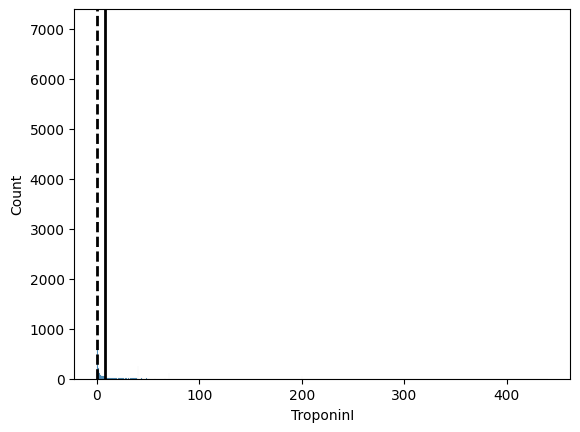

Hct 

31.065073610854707 30.5


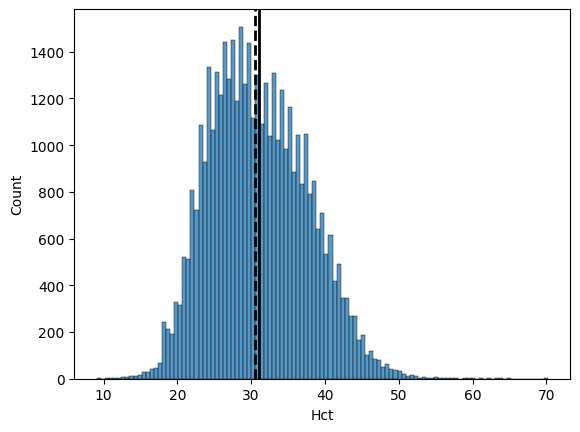

Hgb 

10.201254080957057 9.9


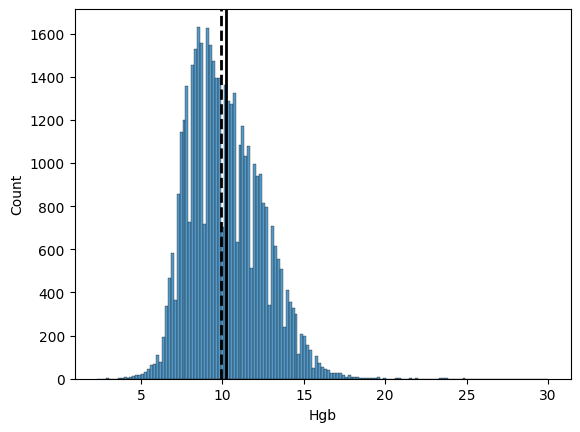

PTT 

43.53121250174409 32.3


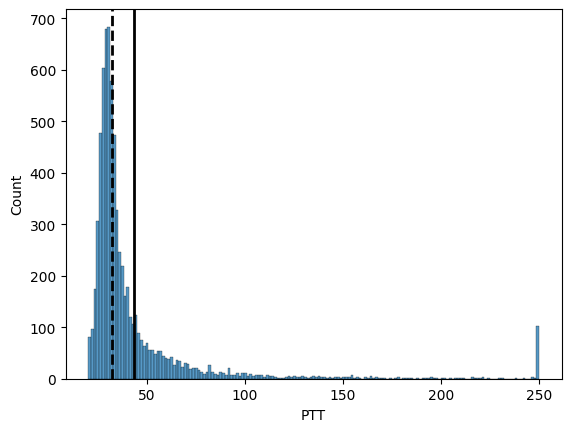

WBC 

10.65941239425135 9.5


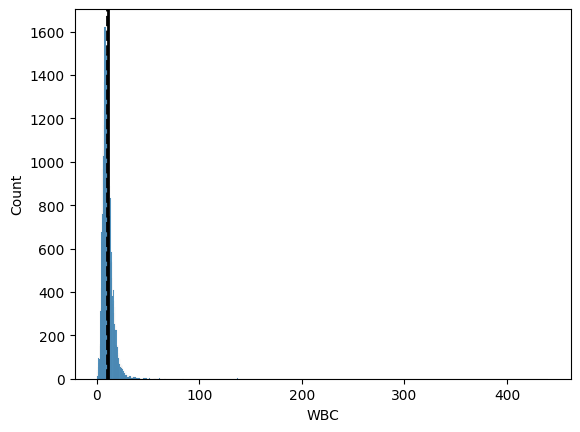

Fibrinogen 

279.5964869480361 251.0


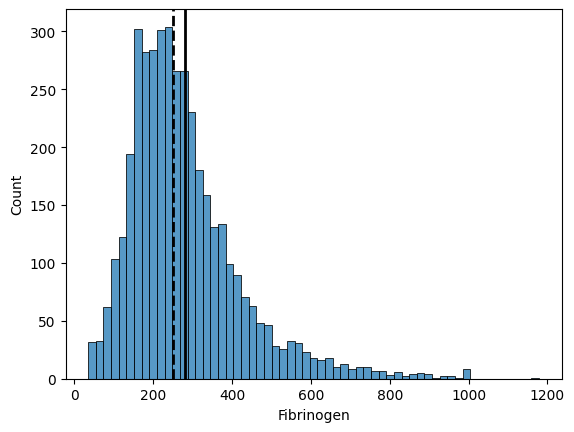

Platelets 

191.81195390177766 180.0


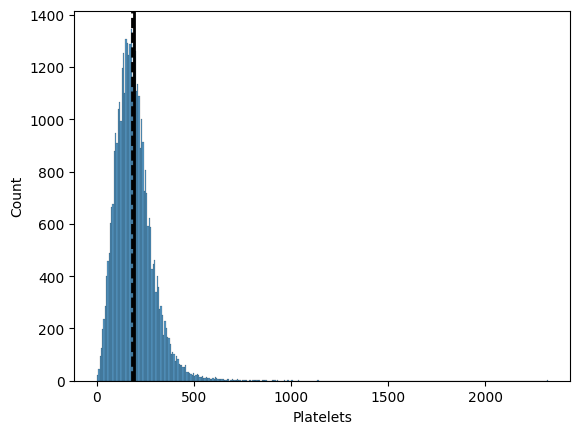

In [ ]:
for v in vitals_fileB.iloc[:,1:-1].columns:
  print(v,'\n')
  x = vitals_fileB[v]
  ax = sns.histplot(x)
  ax.axvline(x.mean(), color='k', lw=2)
  ax.axvline(x.median(), color='k', ls='--', lw=2)
  print(x.mean(),x.median())
  plt.show()

#### Applied Rules

In [ ]:
#Apply all changes
master_fileA.Age = master_fileA.Age.apply(lambda x: setAgeGroup(x))
master_fileB.Age = master_fileB.Age.apply(lambda x: setAgeGroup(x))
master_fileA = master_fileA.drop(columns=['Unit1','Unit2'])
master_fileB = master_fileB.drop(columns=['Unit1','Unit2'])
master_fileA.Gender = master_fileA.Gender.map({1:'Male',0:'Female'})
master_fileB.Gender = master_fileB.Gender.map({1:'Male',0:'Female'})
master_fileA,label_fileA = removeMissing(vitals_fileA,master_fileA,label_fileA)
master_fileB,label_fileB = removeMissing(vitals_fileB,master_fileB,label_fileB)
master_fileA.to_csv('/content/drive/MyDrive/sepsismodel_ctr/masterA.csv',index=False)
master_fileB.to_csv('/content/drive/MyDrive/sepsismodel_ctr/masterB.csv',index=False)

#### Create train, test, val set

In [ ]:
trainA, testA = train_test_split( label_fileA, shuffle=True, test_size=0.3)
testA, valA = train_test_split(testA, shuffle=True, test_size=0.5)
trainA_dict = {}
testA_dict = {}
valA_dict = {}
for ind, row in trainA.iterrows():
  trainA_dict[row.adm_id] = row.SepsisLabel
for ind, row in testA.iterrows():
  testA_dict[row.adm_id] = row.SepsisLabel
for ind, row in valA.iterrows():
  valA_dict[row.adm_id] = row.SepsisLabel
with open(f"/content/drive/MyDrive/sepsismodel_ctr/file/trainA.json",'w') as f:
      f.write(str(trainA_dict))
with open(f"/content/drive/MyDrive/sepsismodel_ctr/file/testA.json",'w') as f:
      f.write(str(testA_dict))
with open(f"/content/drive/MyDrive/sepsismodel_ctr/file/valA.json",'w') as f:
      f.write(str(valA_dict))

trainB, testB = train_test_split( label_fileB, shuffle=True, test_size=0.3)
testB, valB = train_test_split(testB, shuffle=True, test_size=0.5)
trainB_dict = {}
testB_dict = {}
valB_dict = {}
for ind, row in trainB.iterrows():
  trainB_dict[row.adm_id] = row.SepsisLabel
for ind, row in testB.iterrows():
  testB_dict[row.adm_id] = row.SepsisLabel
for ind, row in valB.iterrows():
  valB_dict[row.adm_id] = row.SepsisLabel
with open(f"/content/drive/MyDrive/sepsismodel_ctr/file/trainB.json",'w') as f:
      f.write(str(trainB_dict))
with open(f"/content/drive/MyDrive/sepsismodel_ctr/file/testB.json",'w') as f:
      f.write(str(testB_dict))
with open(f"/content/drive/MyDrive/sepsismodel_ctr/file/valB.json",'w') as f:
      f.write(str(valB_dict))

### Processing Data

1.  Master
  *  Age and gender are the only categorical items remaining
  *  Time from hospital admission to ICU does not appear to be suitable as a categorical variable, as even rounded it has 745 unique values in training set A alone.
  * Data will be stored as a binary string for age and gender categories with a pipe-delimiter followed by the hospital admission time.

2. Vitals
  * Total time in ICU (for prediction period) is calculated and stored
  * Continuous feature values are normalized to equal widths for values between 0 and 1 for all features. This map of value to normalized value is stored.
  * All vitals are given a code based on the index in which they appear



In [ ]:
#Reload Data
master_fileA=pd.read_csv('/content/drive/MyDrive/sepsismodel_ctr/masterA.csv')
master_fileB=pd.read_csv('/content/drive/MyDrive/sepsismodel_ctr/masterB.csv')
label_fileA=pd.read_csv('/content/drive/MyDrive/sepsismodel_ctr/labelA.csv')
label_fileB=pd.read_csv('/content/drive/MyDrive/sepsismodel_ctr/labelB.csv')
vitals_fileA=pd.read_csv('/content/drive/MyDrive/sepsismodel_ctr/vitalA.csv')
vitals_fileB=pd.read_csv('/content/drive/MyDrive/sepsismodel_ctr/vitalB.csv')

def getMasterFeatures(list_of_masters):
  #Get ordered list of features from master, without final continous variable
  master_set = []
  for m in list_of_masters:
    for i, c in enumerate(m.iloc[:,1:-1].columns):
      master_set = master_set + list(m[c].unique())
  master_set = list(np.unique(master_set))
  with open("/content/drive/MyDrive/sepsismodel_ctr/master_features.txt",'w+') as f:
        f.write(str(master_set))

  #Convert patient df to json with string representation
  for imaster, m in enumerate(list_of_masters):
    master_features = {}
    for ind, row in m.iterrows():
      pt_rep = ''
      for itm in master_set:
        if itm in row.to_list():
          pt_rep+='1'
        else:
          pt_rep+='0'
      pt_rep = pt_rep
      master_features[row.adm_id] = pt_rep
    content = json.dumps(master_features,indent=4,ensure_ascii=False)
    save_file = "/content/drive/MyDrive/sepsismodel_ctr/"
    if imaster == 0:
      save_file = save_file + "patient_master_dictA.json"
    elif imaster == 1:
      save_file = save_file + "patient_master_dictB.json"
    with open(save_file,'w') as f:
        f.write(content)
  return

#Get ICU LOS (max timestamp)
def getICULOS(vitals,appendX=''):
  ptICU = {}
  max_icu = vitals.loc[:,['adm_id','ICULOS']].groupby('adm_id').max().reset_index()
  for ind, row in max_icu.iterrows():
    ptICU[row.adm_id] = float(row.ICULOS)
  content = json.dumps(ptICU,indent=4,ensure_ascii=False)
  with open(f"/content/drive/MyDrive/sepsismodel_ctr/patient_time_dict{appendX}.json",'w+') as f:
      f.write(content)
  return

#feature_value_order_dict
def getNormalizedFeatureValues():
  order_dict = {}
  for ind, col in enumerate(vitals_fileA.columns):
    if col == 'adm_id':
      continue
    col_dict = {}
    col_values = []
    col_values += list(vitals_fileA[col].unique())
    col_values += list(vitals_fileB[col].unique())
    col_values = list(set(col_values))
    col_values = [ h for h in col_values if str(h) not in ('nan','NaN','na')]
    spaced_values = np.linspace(0, 1, num=len(col_values))
    for ival, val in enumerate(col_values):
      col_dict[str(val)] = spaced_values[ival]
    order_dict[str(col)] = col_dict

    content = json.dumps(order_dict,indent=4,ensure_ascii=False)
    with open("/content/drive/MyDrive/sepsismodel_ctr/feature_value_order_dict.json",'w+') as f:
        f.write(content)
  return


#Use exisiting files to create a dictionary of patient vitals at different time points
def getPatientRecord(vital_file,appendX=''):
  patient_record = {}
  patient_list = list(vital_file.adm_id.unique())
  with open("/content/drive/MyDrive/sepsismodel_ctr/feature_value_order_dict.json",'r') as f:
    feature_value_order_dict = json.loads(f.read())
    f.close()
  pat_count = 0
  for pat in patient_list:
    if pat_count%100==0:
      print(pat_count)
    patient_record[pat]={}
    pat_data = vital_file.loc[(vital_file.adm_id==pat),:]
    for ind, row in pat_data.iterrows():
      all_vits = []
      for vit_ind, vitl in enumerate(row.index):
        if vitl not in ['adm_id','ICULOS'] and str(row[vitl]).lower() not in ['nan','na']:
          val = feature_value_order_dict[vitl][str(row[vitl])] #map value to normalized
          list_add = [vit_ind,val] #map vital to index
          all_vits.append(list_add)
      if len(all_vits) > 0:
        patient_record[pat][row.ICULOS] = all_vits
    pat_count+=1

  with open(f"/content/drive/MyDrive/sepsismodel_ctr/patient_time_record_dict{appendX}.json", 'w+') as f:
    f.write(json.dumps(patient_record))
  return

#Convert label csv into dict
def getPatientLabels(label_file,appendX=''):
  patient_label_dict = {}
  for ind, row in label_file.iterrows():
    patient_label_dict[row.adm_id] = row.SepsisLabel
  with open(f"/content/drive/MyDrive/sepsismodel_ctr/patient_label_dict{appendX}.json", 'w+') as f:
        f.write(json.dumps(patient_label_dict))
        f.close()
  return

def main_process():
  ##preprocessing
  #master feature file
  getMasterFeatures([master_fileA,master_fileB])

  #max ICU LOS file
  getICULOS(vitals_fileA,'A')
  getICULOS(vitals_fileB,'B')

  #normalize values for all features
  getNormalizedFeatureValues()

  #patient record with all time sorted vitals
  getPatientRecord(vitals_fileA,'A')
  getPatientRecord(vitals_fileB,'B')

  #Convert label csv into dict
  getPatientLabels(label_fileA,'A')
  getPatientLabels(label_fileB,'B')

main_process()


### Run exisiting model

#### Arguments

In [6]:
#Set up arguments

import argparse
parser = argparse.ArgumentParser(description='SepsisModel')
parser.add_argument('-dd',
        '--data-dir',
        type=str,
        default='/content/drive/MyDrive/sepsismodel_ctr/',
        help='data directory'
        )
parser.add_argument(
        '--result-dir',
        type=str,
        default='../result/',
        help='result directory'
        )
parser.add_argument(
        '--file-dir',
        type=str,
        default='../file/',
        help='useful file directory'
        )
parser.add_argument(
        '--vital-file',
        type=str,
        default='../vitalA.csv',
        help='vital information'
        )
parser.add_argument(
        '--master-file',
        type=str,
        default='../masterA.csv',
        help='master information'
        )
parser.add_argument(
        '--label-file',
        type=str,
        default='../labelA.csv',
        help='label'
        )
parser.add_argument(
        '--model',
        '-m',
        type=str,
        default='lstm',
        help='model'
        )
parser.add_argument(
        '--embed-size',
        metavar='EMBED SIZE',
        type=int,
        default=256,
        help='embed size'
        )
parser.add_argument(
        '--rnn-size',
        metavar='rnn SIZE',
        type=int,
        help='rnn size'
        )
parser.add_argument(
        '--hidden-size',
        metavar='hidden SIZE',
        type=int,
        help='hidden size'
        )
parser.add_argument(
        '--split-num',
        metavar='split num',
        type=int,
        default=5,
        help='split num'
        )
parser.add_argument(
        '--split-nor',
        metavar='split normal range',
        type=int,
        default=3,
        help='split num'
        )
parser.add_argument(
        '--num-layers',
        metavar='num layers',
        type=int,
        default=2,
        help='num layers'
        )
parser.add_argument(
        '--num-code',
        metavar='num codes',
        type=int,
        default=1200,
        help='num code'
        )
parser.add_argument(
        '--use-glp',
        metavar='use global pooling operation',
        type=int,
        default=1,
        help='use global pooling operation'
        )
parser.add_argument(
        '--use-visit',
        metavar='use visit as input',
        type=int,
        default=1,
        help='use visit as input'
        )
parser.add_argument(
        '--use-value',
        metavar='use value embedding as input',
        type=int,
        default=1,
        help='use value embedding as input'
        )
parser.add_argument(
        '--use-cat',
        metavar='use cat for time and value embedding',
        type=int,
        default=1,
        help='use cat or add'
        )
parser.add_argument(
        '--use-trend',
        metavar='use feature variation trend',
        type=int,
        default=1,
        help='use trend'
        )
parser.add_argument(
        '--avg-time',
        metavar='avg time for trend, hours',
        type=int,
        default=4,
        help='avg time for trend'
        )
parser.add_argument(
        '--seed',
        metavar='seed',
        type=int,
        default=1,
        help='seed'
        )
parser.add_argument(
        '--set',
        metavar='split set for training',
        type=int,
        default=0,
        help='split set'
        )
parser.add_argument(
        '--last-time',
        metavar='last-time for task2',
        type=int,
        default=-4,
        help='last time'
        )
parser.add_argument(
        '--final',
        metavar='final test to submit',
        type=int,
        default=0,
        help='final'
        )

parser.add_argument('--phase',
        default='train',
        type=str,
        metavar='S',
        help='pretrain/train/test phase')
parser.add_argument(
        '--batch-size',
        '-b',
        metavar='BATCH SIZE',
        type=int,
        default=32,
        help='batch size'
        )
parser.add_argument('--save-dir',
        default='../../data',
        type=str,
        metavar='S',
        help='save dir')
parser.add_argument('--resume',
        default='',
        type=str,
        metavar='S',
        help='start from checkpoints')
parser.add_argument('--task',
        default='task1',
        type=str,
        metavar='S',
        help='start from checkpoints')

#####
parser.add_argument('-j',
        '--workers',
        default=8,
        type=int,
        metavar='N',
        help='number of data loading workers (default: 32)')
parser.add_argument('--lr',
        '--learning-rate',
        default=0.0001,
        type=float,
        metavar='LR',
        help='initial learning rate')
parser.add_argument('--epochs',
        default=20,
        type=int,
        metavar='N',
        help='number of total epochs to run')
parser.add_argument('--save-freq',
        default='5',
        type=int,
        metavar='S',
        help='save frequency')
parser.add_argument('--save-pred-freq',
        default='10',
        type=int,
        metavar='S',
        help='save pred clean frequency')
parser.add_argument('--val-freq',
        default='5',
        type=int,
        metavar='S',
        help='val frequency')
args, unknown = parser.parse_known_args()

args.hard_mining = 0
args.gpu = 1
args.use_trend = max(args.use_trend, args.use_value)
args.use_value = max(args.use_trend, args.use_value)
args.rnn_size = args.embed_size
args.hidden_size = args.embed_size

#### Model helper functions

In [7]:
def save_model(p_dict, name='best.ckpt', folder='/content/drive/MyDrive/sepsismodel_ctr/models/'):
    args = p_dict['args']
    name = '{:s}-snm-{:d}-snr-{:d}-value-{:d}-trend-{:d}-cat-{:d}-lt-{:d}-size-{:d}-seed-{:d}-{:s}'.format(args.task, 
            args.split_num, args.split_nor, args.use_value, args.use_trend, 
            args.use_cat, args.last_time, args.embed_size, args.seed, name)
    if not os.path.exists(folder):
        os.mkdir(folder)
    model = p_dict['model']
    state_dict = model.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].cpu()
    all_dict = {
            'epoch': p_dict['epoch'],
            'args': p_dict['args'],
            'best_metric': p_dict['best_metric'],
            'state_dict': state_dict 
            }
    torch.save(all_dict, os.path.join(folder, name))

def load_model(p_dict, model_file):
    all_dict = torch.load(model_file)
    p_dict['epoch'] = all_dict['epoch']
    p_dict['best_metric'] = all_dict['best_metric']
    p_dict['model'].load_state_dict(all_dict['state_dict'])


def save_segmentation_results(images, segmentations, folder='../data/middle_segmentation'):
    stride = args.stride

    if not os.path.exists(folder):
        os.mkdir(folder)

    images = (images * 128) + 127
    segmentations[segmentations>0] = 255
    segmentations[segmentations<0] = 0

    for ii, image, seg in zip(range(len(images)), images, segmentations):
        image = data_function.numpy_to_image(image)
        new_seg = np.zeros([3, seg.shape[1] * stride, seg.shape[2] * stride])
        for i in range(seg.shape[1]):
            for j in range(seg.shape[2]):
                for k in range(3):
                    new_seg[k, i*stride:(i+1)*stride, j*stride:(j+1)*stride] = seg[0,i,j]
        seg = new_seg
        seg = data_function.numpy_to_image(seg)
        image.save(os.path.join(folder, str(ii) + '_image.png'))
        seg.save(os.path.join(folder, str(ii) + '_seg.png'))


def save_middle_results(data, folder = '../data/middle_images'):
    stride = args.stride

    if not os.path.exists(folder):
        os.mkdir(folder)
    numpy_data = [x.data.numpy() for x in data[1:]]
    data =  data[:1] + numpy_data
    image_names, images, word_labels, seg_labels, bbox_labels, bbox_images =  data[:6]
    images = (images * 128) + 127
    seg_labels = seg_labels*127 + 127


    for ii, name, image, seg, bbox_image in zip(range(len(image_names)), image_names, images, seg_labels, bbox_images):
        name = name.split('/')[-1]
        image = data_function.numpy_to_image(image)
        new_seg = np.zeros([3, seg.shape[1] * stride, seg.shape[2] * stride])
        for i in range(seg.shape[1]):
            for j in range(seg.shape[2]):
                for k in range(3):
                    new_seg[k, i*stride:(i+1)*stride, j*stride:(j+1)*stride] = seg[0,i,j]
        seg = new_seg
        seg = data_function.numpy_to_image(seg)

        image.save(os.path.join(folder, str(ii) + '_image.png'))
        seg.save(os.path.join(folder, str(ii) + '_seg.png'))

        for ib,bimg in enumerate(bbox_image):

            bimg = data_function.numpy_to_image(bimg)
            bimg.save(os.path.join(folder, str(ii)+'_'+ str(ib) + '_bbox.png'))

def save_detection_results(names, images, detect_character_output, folder='../data/test_results/'):
    stride = args.stride

    if not os.path.exists(folder):
        os.mkdir(folder)
    images = (images * 128) + 127

    for i, name, image, bboxes in zip(range(len(names)), names, images, detect_character_output):
        name = name.split('/')[-1]
        data_function.numpy_to_image(image).save(os.path.join(folder, str(i) + '_image.png'))
        detected_bbox = detect_function.nms(bboxes)
        image = data_function.add_bbox_to_image(image, detected_bbox)
        image.save(os.path.join(folder, str(i) + '_bbox.png'))



def compute_detection_metric(outputs, labels, loss_outputs,metric_dict):
    loss_outputs[0] = loss_outputs[0].data
    metric_dict['metric'] = metric_dict.get('metric', []) + [loss_outputs]

def compute_segmentation_metric(outputs, labels, loss_outputs, metric_dict):
    loss_outputs[0] = loss_outputs[0].data
    metric_dict['metric'] = metric_dict.get('metric', []) + [loss_outputs]

def compute_metric(outputs, labels, time, loss_outputs,metric_dict, phase='train'):
    # loss_output_list, f1score_list, recall_list, precision_list):
    if phase != 'test':
        preds = outputs.data.cpu().numpy()
        labels = labels.data.cpu().numpy()
    else:
        preds = np.array(outputs)

    preds = preds.reshape(-1)
    labels = labels.reshape(-1)

    if time is not None:
        time = time.reshape(-1)
        assert preds.shape == time.shape
        time = time[labels>-0.5]
    assert preds.shape == labels.shape

    preds = preds[labels>-0.5]
    label = labels[labels>-0.5]

    pred = preds > 0

    assert len(pred) == len(label)

    tp = (pred + label == 2).sum()
    tn = (pred + label == 0).sum()
    fp = (pred - label == 1).sum()
    fn = (pred - label ==-1).sum()
    fp = (pred - label == 1).sum()

    metric_dict['tp'] = metric_dict.get('tp', 0.0) + tp
    metric_dict['tn'] = metric_dict.get('tn', 0.0) + tn
    metric_dict['fp'] = metric_dict.get('fp', 0.0) + fp
    metric_dict['fn'] = metric_dict.get('fn', 0.0) + fn
    loss = []
    for x in loss_outputs:
        if x == 0:
            loss.append(x)
        else:
            loss.append(x.data.cpu().numpy())
    # loss = [[x.data.cpu().numpy() for x in loss_outputs]]
    metric_dict['loss'] = metric_dict.get('loss', []) +  [loss]
    if phase != 'train':
        metric_dict['preds'] = metric_dict.get('preds', []) + list(preds)
        metric_dict['labels'] = metric_dict.get('labels', []) + list(label)
        if time is not None:
            metric_dict['times'] = metric_dict.get('times', []) + list(time)

def compute_metric_multi_classification(outputs, labels, loss_outputs, metric_dict):
    preds = outputs.data.cpu().numpy() > 0
    labels = labels.data.cpu().numpy()
    for pred, label in zip(preds, labels):
        pred = np.argmax(pred)
        tp = (pred == label ).sum()
        fn = (pred != label).sum()
        accuracy = 1.0 * tp / (tp + fn)
        metric_dict['accuracy'] = metric_dict.get('accuracy', []) + [accuracy]
    metric_dict['loss'] = metric_dict.get('loss', []) +  [[x.data.cpu().numpy() for x in loss_outputs]]


def print_metric(first_line, metric_dict, phase='train'):
    print(first_line)
    loss_array = np.array(metric_dict['loss']).mean(0)
    tp = metric_dict['tp']
    tn = metric_dict['tn']
    fp = metric_dict['fp']
    fn = metric_dict['fn']
    accuracy = 1.0 * (tp + tn) / (tp + tn + fp + fn)
    recall = 1.0 * tp / (tp + fn + 10e-20)
    precision = 1.0 * tp / (tp + fp + 10e-20)
    f1score = 2.0 * recall * precision / (recall + precision + 10e-20)


    
    loss_array = loss_array.reshape(-1)

    print('loss: {:3.4f}\t pos loss: {:3.4f}\t negloss: {:3.4f}'.format(loss_array[0], loss_array[1], loss_array[2]))
    print('accuracy: {:3.4f}\t f1score: {:3.4f}\t recall: {:3.4f}\t precision: {:3.4f}'.format(accuracy, f1score, recall, precision))
    print('\n')

    if phase != 'train':
        fpr, tpr, thr = metrics.roc_curve(metric_dict['labels'], metric_dict['preds'])
        return metrics.auc(fpr, tpr)
    else:
        return f1score


#### Model class

In [8]:
import os
import json
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import *

import numpy as np

import sys
os.chdir('/content/drive/MyDrive/sepsismodel/code/tools/')
import py_op
#args = parse.args

args.hard_mining = 0
args.gpu = 1
args.use_trend = max(args.use_trend, args.use_value)
args.use_value = max(args.use_trend, args.use_value)
args.rnn_size = args.embed_size
args.hidden_size = args.embed_size

def time_encoding_data(d = 512, time = 200):
    vec = np.array([np.arange(time) * i for i in range(int(d/2))], dtype=np.float32).transpose()
    vec = vec / vec.max() / 2
    encoding = np.concatenate((np.sin(vec), np.cos(vec)), 1)
    encoding = torch.from_numpy(encoding)
    return encoding


class LSTM(nn.Module):
    def __init__(self, opt):
        super ( LSTM, self ).__init__ ( )
        self.use_cat = args.use_cat
        self.avg_time = args.avg_time

        self.embedding = nn.Embedding (opt.vocab_size, opt.embed_size )
        self.lstm = nn.LSTM ( input_size=opt.embed_size,
                              hidden_size=opt.hidden_size,
                              num_layers=opt.num_layers,
                              batch_first=True,
                              bidirectional=True)


        no = 1
        if self.use_cat:
            no += 1
        self.output_time = nn.Sequential (
                nn.Linear(opt.embed_size * no, opt.embed_size),
                nn.ReLU ( ),
        )

        time = 200
        self.time_encoding = nn.Embedding.from_pretrained(time_encoding_data(opt.embed_size, time))
        self.time_mapping = nn.Sequential (
            nn.Linear ( opt.embed_size, opt.embed_size),
            nn.ReLU ( ),
            nn.Dropout ( 0.25 ),
            nn.Linear ( opt.embed_size, opt.embed_size)
            )

        self.embed_linear = nn.Sequential (
            nn.Linear ( opt.embed_size, opt.embed_size),
            nn.ReLU ( ),
            nn.Dropout ( 0.25 ),
            nn.Linear ( opt.embed_size, opt.embed_size),
            nn.ReLU ( ),
            nn.Dropout ( 0.25 ),
        )
        self.relu = nn.ReLU ( )

        self.linears = nn.Sequential (
            nn.Linear ( opt.hidden_size * 2, opt.rnn_size ),
            nn.ReLU ( ),
            nn.Dropout ( 0.25 ),
            nn.Linear ( opt.rnn_size, 1),
        )
        mn = 128
        self.master_linear = nn.Sequential (
            nn.Linear ( 43, mn),
            nn.ReLU ( ),
            nn.Dropout ( 0.25 ),
            nn.Linear ( mn, mn),
            nn.ReLU ( ),
            nn.Dropout ( 0.25 ),
            nn.Linear ( mn, 1),
        )
        self.output = nn.Sequential (
            nn.Linear ( mn + opt.rnn_size , opt.rnn_size),
            nn.ReLU ( ),
            nn.Linear ( opt.rnn_size, mn),
            nn.ReLU ( ),
            nn.Dropout ( 0.25 ),
            nn.Linear ( mn, 1),
        )
        self.pooling = nn.AdaptiveMaxPool1d(1)
        self.opt = opt

    def visit_pooling(self, x, mask, time, value=None, trend=None):

        output = x
        size = output.size()
        output = output.view(size[0] * size[1], size[2], output.size(3)) # (bs*98, 72, 512)
        if args.use_glp:
            output = torch.transpose(output, 1,2).contiguous() # (bs*98, 512, 72)
            output = self.pooling(output)
        else:
            weight = self.alpha(output) # (bs*98, 72, 1)
            # print weight.size()
            weight = weight.view(size[0]*size[1], size[2])
            # print weight.size()
            weight = F.softmax(weight)
            x = weight.data.cpu().numpy()
            # print x.shape
            weight = weight.view(size[0]*size[1], size[2], 1).expand(output.size())
            output = weight * output # (bs*98, 512, 72)
            # print output.size()
            output = output.sum(1)
            # print output.size()
            # output = torch.transpose(output, 1,2).contiguous() 
        output = output.view(size[0], size[1], size[3])

        # time encoding
        time = - time.long()
        time = self.time_encoding(time)
        time = self.time_mapping(time)

        if self.use_cat:
            output = torch.cat((output, time), 2) 
            output = self.relu(output)
            output = self.output_time(output) 
        else:
            output = output + time
            output = self.relu(output)



        return output


    def forward_2(self, x, master, mask=None, time=None, phase='train', value=None, trend=None):
        '''
        task2
        '''
        size = list(x.size())
        x = x.view(-1)
        x = self.embedding( x )
        x = self.embed_linear(x)
        size.append(-1)
        x = x.view(size)
        if mask is not None:
            x = self.visit_pooling(x, mask, time, value, trend)
        lstm_out, _ = self.lstm( x )
        lstm_out = torch.transpose(lstm_out, 1, 2).contiguous() 
        mask = self.pooling(mask)
        # print 'mask', mask.size()
        pool_out = []
        mask_out = []
        time_out = []
        time = time.data.cpu().numpy()
        if phase == 'train':
            start, delta = 4, 6
        else:
            start, delta = 1, 1
        for i in range(start, lstm_out.size(2), delta):
            pool_out.append(self.pooling(lstm_out[:,:, :i]))
            mask_out.append(mask[:, i])
            time_out.append(time[:, i])
        pool_out.append(self.pooling(lstm_out))
        mask_out.append(mask[:, 0])
        time_out.append(np.zeros(size[0]) - 4)

        lstm_out = torch.cat(pool_out, 2)  
        mask_out = torch.cat(mask_out, 1)  
        time_out = np.array(time_out).transpose() 

        lstm_out = torch.transpose(lstm_out, 1, 2).contiguous() 

        out_vital = self.linears(lstm_out)
        size = list(out_vital.size())
        out_vital = out_vital.view(size[:2])
        out_master = self.master_linear(master).expand(size[:2])
        out = out_vital + out_master
        return out, mask_out, time_out

    def forward_1(self, x, master, mask=None, time=None, phase='train', value=None, trend=None):
  
        size = list(x.size())
        x = x.view(-1)
        x = self.embedding( x )

        x = self.embed_linear(x)
        size.append(-1)
        x = x.view(size)
        if mask is not None:
            x = self.visit_pooling(x, mask, time, value, trend)
        lstm_out, _ = self.lstm( x )

        lstm_out = torch.transpose(lstm_out, 1, 2).contiguous()
        lstm_out = self.pooling(lstm_out)
        lstm_out = lstm_out.view(lstm_out.size(0), -1)

        out = self.linears(lstm_out) + self.master_linear(master)
        return out

    def forward(self, x, master, mask=None, time=None, phase='train', value=None, trend=None):
        if args.task == 'task2':
            return self.forward_2(x, master, mask, time, phase, value, trend)
            # return self.forward_1(x, master, mask, time, phase, value, trend)
        else:
            return self.forward_1(x, master, mask, time, phase, value, trend)

#### Main Run

In [9]:
#Main run (No6)
import os
import sys
import time
import json
import traceback
import numpy as np
from glob import glob
from tqdm import tqdm
from sklearn import metrics


# torch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
os.chdir('/content/drive/MyDrive/sepsismodel/code/tools/')
#import parse, 
import py_op

os.chdir('/content/drive/MyDrive/sepsismodel/code')
import loss
#import function

# import framework
os.chdir('/content/drive/MyDrive/sepsismodel/code/loaddata')
import dataloader

os.chdir('/content/drive/MyDrive/sepsismodel/code/models')
import lstm

def train_eval(p_dict, phase='train'):
    epoch = p_dict['epoch']
    model = p_dict['model']           
    loss = p_dict['loss']             
    if phase == 'train':
        data_loader = p_dict['train_loader']        
        optimizer = p_dict['optimizer']             
    else:
        data_loader = p_dict['val_loader']

    classification_metric_dict = dict()

    for i,data in enumerate(tqdm(data_loader)):
        if args.use_visit:
            if args.gpu:
                data = [ Variable(x.cuda()) for x in data ]
            visits, values, mask, master, labels, times, trends  = data
            if i == 0:
                print('input size', visits.size())
            output = model(visits, master, mask, times, phase, values, trends)
        else:
            inputs = Variable(data[0].cuda())
            labels = Variable(data[1].cuda())
            output = model(inputs)

        # if 0:
        if args.task == 'task2':
            output, mask, time = output
            labels = labels.unsqueeze(-1).expand(output.size()).contiguous()
            labels[mask==0] = -1
        else:
            time = None

        classification_loss_output = loss(output, labels, args.hard_mining)
        loss_gradient = classification_loss_output[0]
        compute_metric(output, labels, time, classification_loss_output, classification_metric_dict, phase)

        if phase == 'train':
            optimizer.zero_grad()
            loss_gradient.backward()
            optimizer.step()

    print('\nEpoch: {:d} \t Phase: {:s} \n'.format(epoch, phase))
    metric = print_metric('classification', classification_metric_dict, phase)
    if args.phase != 'train':
        print('metric = ', metric,'\n','\n')
        return
    if phase == 'val':
        if metric > p_dict['best_metric'][0]:
            p_dict['best_metric'] = [metric, epoch]
            save_model(p_dict)
            if 0:
                preds = classification_metric_dict['preds'] 
                labels = classification_metric_dict['labels'] 
                times = classification_metric_dict['times'] 
                fl = open('/content/drive/MyDrive/sepsismodel/result/tauc_label.csv', 'w')
                fr = open('/content/drive/MyDrive/sepsismodel/result/tauc_result.csv', 'w')
                fl.write('adm_id,last_event_time,mortality\n')
                fr.write('adm_id,probability\n')
                for i, (p,l,t) in enumerate(zip(preds, labels, times)):
                    if i % 30:
                        continue
                    fl.write(str(i) + ',')
                    fl.write(str(t) + ',')
                    fl.write(str(int(l)) + '\n')

                    fr.write(str(i) + ',')
                    fr.write(str(p) + '\n')


        print('valid: metric: {:3.4f}\t epoch: {:d}\n'.format(metric, epoch))
        print('\t\t\t valid: best_metric: {:3.4f}\t epoch: {:d}\n'.format(p_dict['best_metric'][0], p_dict['best_metric'][1]))  
    else:
        print('train: metric: {:3.4f}\t epoch: {:d}\n'.format(metric, epoch))



def main():
    print(args.task)
    p_dict = dict() # All the parameters
    p_dict['args'] = args
    args.split_nn = args.split_num + args.split_nor * 3
    args.vocab_size = args.split_nn * 145 + 1
    print('vocab_size', args.vocab_size)

    ### load data
    print('read data ...')
    patient_time_record_dict = py_op.myreadjson('/content/drive/MyDrive/sepsismodel/runfiles/patient_time_record_dict.json')
    patient_master_dict = py_op.myreadjson('/content/drive/MyDrive/sepsismodel/runfiles/patient_master_dict.json')
    patient_label_dict = py_op.myreadjson('/content/drive/MyDrive/sepsismodel/runfiles/patient_label_dict.json')

    patient_train = list(json.load(open(os.path.join("/content/drive/MyDrive/sepsismodel_ctr/file/trainA.json"))))
    patient_valid = list(json.load(open(os.path.join("/content/drive/MyDrive/sepsismodel_ctr/file/valA.json")))) 

    if len(patient_train) > len(patient_label_dict):
        patients = list(patient_label_dict.keys())
        n = int(0.8 * len(patients))
        patient_train = patients[:n]
        patient_valid = patients[n:]

    # patient_time_record_dict = py_op.myreadjson('/content/drive/MyDrive/sepsismodel_ctr/patient_time_record_dictA.json')
    # ind = 0
    # good_ind = 0
    # short_patient_time_record_dict = {}
    # for k in patient_time_record_dict.keys():
    #   if len(patient_time_record_dict[k])>=49:
    #     continue
    #   else:
    #     short_patient_time_record_dict[k]=patient_time_record_dict[k]
    #     good_ind+=1
    #   ind+=1
    #   if good_ind>90:
    #     break
    # patient_time_record_dict = short_patient_time_record_dict
    # patient_master_dict = py_op.myreadjson('/content/drive/MyDrive/sepsismodel_ctr/patient_master_dictA.json')
    # patient_label_dict = py_op.myreadjson('/content/drive/MyDrive/sepsismodel_ctr/patient_label_dictA.json')

    # patient_train = list(json.load(open(os.path.join("/content/drive/MyDrive/sepsismodel_ctr/file/trainA.json"))))
    # patient_valid = list(json.load(open(os.path.join("/content/drive/MyDrive/sepsismodel_ctr/file/valA.json")))) 

    # if len(patient_train) > len(patient_label_dict):
    # patients = list(short_patient_time_record_dict.keys())
    # n = int(0.8 * len(patients))
    # patient_train = patients[:n]
    # patient_valid = patients[n:]

    print('data loading ...')
    train_dataset  = dataloader.DataSet(
                patient_train, 
                patient_time_record_dict,
                patient_label_dict,
                patient_master_dict, 
                args=args,
                phase='train')
    train_loader = DataLoader(
                dataset=train_dataset, 
                batch_size=args.batch_size,
                shuffle=True, 
                num_workers=2, 
                pin_memory=True)
    val_dataset  = dataloader.DataSet(
                patient_valid, 
                patient_time_record_dict,
                patient_label_dict,
                patient_master_dict, 
                args=args,
                phase='val')
    val_loader = DataLoader(
                dataset=val_dataset, 
                batch_size=args.batch_size,
                shuffle=False, 
                num_workers=2, 
                pin_memory=True)

    p_dict['train_loader'] = train_loader
    p_dict['val_loader'] = val_loader



    cudnn.benchmark = True
    net = LSTM(args)
    if args.gpu:
        net = net.cuda()
        p_dict['loss'] = loss.Loss().cuda()
    else:
        p_dict['loss'] = loss.Loss()

    parameters = []
    for p in net.parameters():
        parameters.append(p)
    optimizer = torch.optim.Adam(parameters, lr=args.lr)
    p_dict['optimizer'] = optimizer
    p_dict['model'] = net
    start_epoch = 0

    p_dict['epoch'] = 0
    p_dict['best_metric'] = [0, 0]


    ### resume pretrained model
    if os.path.exists(args.resume):
        print('resume from model ' + args.resume)
        function.load_model(p_dict, args.resume)
        print('best_metric', p_dict['best_metric'])
        # return


    if args.phase == 'train':

        best_f1score = 0
        for epoch in range(p_dict['epoch'] + 1, args.epochs):
            p_dict['epoch'] = epoch
            for param_group in optimizer.param_groups:
                param_group['lr'] = args.lr
            train_eval(p_dict, 'train')
            train_eval(p_dict, 'val')

    return p_dict
  
model_dict = main()


task1
vocab_size 2031
read data ...
data loading ...


  0%|          | 0/3 [00:00<?, ?it/s]

input size torch.Size([32, 49, 72])


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]



Epoch: 1 	 Phase: train 

classification
loss: 0.5742	 pos loss: 0.2412	 negloss: 0.3330
accuracy: 0.5972	 f1score: 0.1212	 recall: 0.0714	 precision: 0.4000


train: metric: 0.1212	 epoch: 1



100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


input size torch.Size([18, 49, 72])

Epoch: 1 	 Phase: val 

classification
loss: 0.6940	 pos loss: 0.3589	 negloss: 0.3351
accuracy: 0.6111	 f1score: 0.0000	 recall: 0.0000	 precision: 0.0000


valid: metric: 0.5538	 epoch: 1

			 valid: best_metric: 0.5538	 epoch: 1



  0%|          | 0/3 [00:00<?, ?it/s]

input size torch.Size([32, 49, 72])


100%|██████████| 3/3 [00:00<00:00,  9.08it/s]



Epoch: 2 	 Phase: train 

classification
loss: 0.6934	 pos loss: 0.3653	 negloss: 0.3281
accuracy: 0.6111	 f1score: 0.0667	 recall: 0.0357	 precision: 0.5000


train: metric: 0.0667	 epoch: 2



100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


input size torch.Size([18, 49, 72])

Epoch: 2 	 Phase: val 

classification
loss: 0.6834	 pos loss: 0.3559	 negloss: 0.3276
accuracy: 0.7778	 f1score: 0.5000	 recall: 0.4000	 precision: 0.6667


valid: metric: 0.7231	 epoch: 2

			 valid: best_metric: 0.7231	 epoch: 2



100%|██████████| 3/3 [00:00<00:00,  9.45it/s]


input size torch.Size([32, 49, 72])

Epoch: 3 	 Phase: train 

classification
loss: 0.6958	 pos loss: 0.3667	 negloss: 0.3291
accuracy: 0.6389	 f1score: 0.1333	 recall: 0.0714	 precision: 1.0000


train: metric: 0.1333	 epoch: 3



100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


input size torch.Size([18, 49, 72])

Epoch: 3 	 Phase: val 

classification
loss: 0.6892	 pos loss: 0.3623	 negloss: 0.3269
accuracy: 0.7778	 f1score: 0.3333	 recall: 0.2000	 precision: 1.0000


valid: metric: 0.5231	 epoch: 3

			 valid: best_metric: 0.7231	 epoch: 2



  0%|          | 0/3 [00:00<?, ?it/s]

input size torch.Size([32, 49, 72])


100%|██████████| 3/3 [00:00<00:00,  9.75it/s]



Epoch: 4 	 Phase: train 

classification
loss: 0.6956	 pos loss: 0.3682	 negloss: 0.3274
accuracy: 0.6111	 f1score: 0.0667	 recall: 0.0357	 precision: 0.5000


train: metric: 0.0667	 epoch: 4



100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


input size torch.Size([18, 49, 72])

Epoch: 4 	 Phase: val 

classification
loss: 0.6907	 pos loss: 0.3656	 negloss: 0.3252
accuracy: 0.7222	 f1score: 0.0000	 recall: 0.0000	 precision: 0.0000


valid: metric: 0.6308	 epoch: 4

			 valid: best_metric: 0.7231	 epoch: 2



  0%|          | 0/3 [00:00<?, ?it/s]

input size torch.Size([32, 49, 72])


100%|██████████| 3/3 [00:00<00:00, 10.14it/s]



Epoch: 5 	 Phase: train 

classification
loss: 0.6909	 pos loss: 0.3643	 negloss: 0.3266
accuracy: 0.5972	 f1score: 0.0000	 recall: 0.0000	 precision: 0.0000


train: metric: 0.0000	 epoch: 5



100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


input size torch.Size([18, 49, 72])

Epoch: 5 	 Phase: val 

classification
loss: 0.6939	 pos loss: 0.3667	 negloss: 0.3271
accuracy: 0.7222	 f1score: 0.0000	 recall: 0.0000	 precision: 0.0000


valid: metric: 0.5231	 epoch: 5

			 valid: best_metric: 0.7231	 epoch: 2



100%|██████████| 3/3 [00:00<00:00,  8.94it/s]


input size torch.Size([32, 49, 72])

Epoch: 6 	 Phase: train 

classification
loss: 0.6885	 pos loss: 0.3611	 negloss: 0.3274
accuracy: 0.6250	 f1score: 0.1290	 recall: 0.0714	 precision: 0.6667


train: metric: 0.1290	 epoch: 6



100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


input size torch.Size([18, 49, 72])

Epoch: 6 	 Phase: val 

classification
loss: 0.6868	 pos loss: 0.3610	 negloss: 0.3259
accuracy: 0.7222	 f1score: 0.0000	 recall: 0.0000	 precision: 0.0000


valid: metric: 0.6923	 epoch: 6

			 valid: best_metric: 0.7231	 epoch: 2



  0%|          | 0/3 [00:00<?, ?it/s]

input size torch.Size([32, 49, 72])


100%|██████████| 3/3 [00:00<00:00, 10.00it/s]



Epoch: 7 	 Phase: train 

classification
loss: 0.6950	 pos loss: 0.3637	 negloss: 0.3313
accuracy: 0.5972	 f1score: 0.1212	 recall: 0.0714	 precision: 0.4000


train: metric: 0.1212	 epoch: 7



100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


input size torch.Size([18, 49, 72])

Epoch: 7 	 Phase: val 

classification
loss: 0.6863	 pos loss: 0.3569	 negloss: 0.3294
accuracy: 0.7222	 f1score: 0.2857	 recall: 0.2000	 precision: 0.5000


valid: metric: 0.7077	 epoch: 7

			 valid: best_metric: 0.7231	 epoch: 2



  0%|          | 0/3 [00:00<?, ?it/s]

input size

100%|██████████| 3/3 [00:00<00:00, 10.06it/s]


 torch.Size([32, 49, 72])

Epoch: 8 	 Phase: train 

classification
loss: 0.6841	 pos loss: 0.3578	 negloss: 0.3263
accuracy: 0.6250	 f1score: 0.1290	 recall: 0.0714	 precision: 0.6667


train: metric: 0.1290	 epoch: 8



100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


input size torch.Size([18, 49, 72])

Epoch: 8 	 Phase: val 

classification
loss: 0.6841	 pos loss: 0.3506	 negloss: 0.3335
accuracy: 0.6667	 f1score: 0.2500	 recall: 0.2000	 precision: 0.3333


valid: metric: 0.7231	 epoch: 8

			 valid: best_metric: 0.7231	 epoch: 2



100%|██████████| 3/3 [00:00<00:00,  9.83it/s]


input size torch.Size([32, 49, 72])

Epoch: 9 	 Phase: train 

classification
loss: 0.6924	 pos loss: 0.3589	 negloss: 0.3334
accuracy: 0.5972	 f1score: 0.1212	 recall: 0.0714	 precision: 0.4000


train: metric: 0.1212	 epoch: 9



100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


input size torch.Size([18, 49, 72])

Epoch: 9 	 Phase: val 

classification
loss: 0.6770	 pos loss: 0.3470	 negloss: 0.3299
accuracy: 0.7778	 f1score: 0.5000	 recall: 0.4000	 precision: 0.6667


valid: metric: 0.9077	 epoch: 9

			 valid: best_metric: 0.9077	 epoch: 9



100%|██████████| 3/3 [00:00<00:00, 10.65it/s]


input size torch.Size([32, 49, 72])

Epoch: 10 	 Phase: train 

classification
loss: 0.6896	 pos loss: 0.3555	 negloss: 0.3341
accuracy: 0.6528	 f1score: 0.3902	 recall: 0.2857	 precision: 0.6154


train: metric: 0.3902	 epoch: 10



100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


input size torch.Size([18, 49, 72])

Epoch: 10 	 Phase: val 

classification
loss: 0.6985	 pos loss: 0.3595	 negloss: 0.3390
accuracy: 0.6111	 f1score: 0.2222	 recall: 0.2000	 precision: 0.2500


valid: metric: 0.3846	 epoch: 10

			 valid: best_metric: 0.9077	 epoch: 9



100%|██████████| 3/3 [00:00<00:00, 10.10it/s]


input size torch.Size([32, 49, 72])

Epoch: 11 	 Phase: train 

classification
loss: 0.6926	 pos loss: 0.3570	 negloss: 0.3355
accuracy: 0.5556	 f1score: 0.1579	 recall: 0.1071	 precision: 0.3000


train: metric: 0.1579	 epoch: 11



100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


input size torch.Size([18, 49, 72])

Epoch: 11 	 Phase: val 

classification
loss: 0.6864	 pos loss: 0.3491	 negloss: 0.3373
accuracy: 0.7222	 f1score: 0.4444	 recall: 0.4000	 precision: 0.5000


valid: metric: 0.6769	 epoch: 11

			 valid: best_metric: 0.9077	 epoch: 9



  0%|          | 0/3 [00:00<?, ?it/s]

input size torch.Size([32, 49, 72])


100%|██████████| 3/3 [00:00<00:00, 10.29it/s]



Epoch: 12 	 Phase: train 

classification
loss: 0.6909	 pos loss: 0.3545	 negloss: 0.3364
accuracy: 0.5417	 f1score: 0.2326	 recall: 0.1786	 precision: 0.3333


train: metric: 0.2326	 epoch: 12



100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


input size torch.Size([18, 49, 72])

Epoch: 12 	 Phase: val 

classification
loss: 0.6845	 pos loss: 0.3494	 negloss: 0.3351
accuracy: 0.7222	 f1score: 0.5455	 recall: 0.6000	 precision: 0.5000


valid: metric: 0.7231	 epoch: 12

			 valid: best_metric: 0.9077	 epoch: 9



  0%|          | 0/3 [00:00<?, ?it/s]

input size torch.Size([32, 49, 72])


100%|██████████| 3/3 [00:00<00:00, 10.77it/s]



Epoch: 13 	 Phase: train 

classification
loss: 0.6845	 pos loss: 0.3494	 negloss: 0.3351
accuracy: 0.6806	 f1score: 0.5106	 recall: 0.4286	 precision: 0.6316


train: metric: 0.5106	 epoch: 13



100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


input size torch.Size([18, 49, 72])

Epoch: 13 	 Phase: val 

classification
loss: 0.6965	 pos loss: 0.3477	 negloss: 0.3489
accuracy: 0.5000	 f1score: 0.3077	 recall: 0.4000	 precision: 0.2500


valid: metric: 0.4615	 epoch: 13

			 valid: best_metric: 0.9077	 epoch: 9



  0%|          | 0/3 [00:00<?, ?it/s]

input size torch.Size([32, 49, 72])


100%|██████████| 3/3 [00:00<00:00, 10.88it/s]



Epoch: 14 	 Phase: train 

classification
loss: 0.6958	 pos loss: 0.3533	 negloss: 0.3425
accuracy: 0.5694	 f1score: 0.2791	 recall: 0.2143	 precision: 0.4000


train: metric: 0.2791	 epoch: 14



100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


input size torch.Size([18, 49, 72])

Epoch: 14 	 Phase: val 

classification
loss: 0.6833	 pos loss: 0.3444	 negloss: 0.3389
accuracy: 0.8333	 f1score: 0.7273	 recall: 0.8000	 precision: 0.6667


valid: metric: 0.8462	 epoch: 14

			 valid: best_metric: 0.9077	 epoch: 9



  0%|          | 0/3 [00:00<?, ?it/s]

input size torch.Size([32, 49, 72])


100%|██████████| 3/3 [00:00<00:00, 10.20it/s]



Epoch: 15 	 Phase: train 

classification
loss: 0.6896	 pos loss: 0.3486	 negloss: 0.3411
accuracy: 0.5278	 f1score: 0.3929	 recall: 0.3929	 precision: 0.3929


train: metric: 0.3929	 epoch: 15



100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


input size torch.Size([18, 49, 72])

Epoch: 15 	 Phase: val 

classification
loss: 0.6965	 pos loss: 0.3478	 negloss: 0.3487
accuracy: 0.4444	 f1score: 0.2857	 recall: 0.4000	 precision: 0.2222


valid: metric: 0.4615	 epoch: 15

			 valid: best_metric: 0.9077	 epoch: 9



  0%|          | 0/3 [00:00<?, ?it/s]

input size torch.Size([32, 49, 72])


100%|██████████| 3/3 [00:00<00:00, 10.71it/s]



Epoch: 16 	 Phase: train 

classification
loss: 0.6897	 pos loss: 0.3493	 negloss: 0.3404
accuracy: 0.5556	 f1score: 0.4286	 recall: 0.4286	 precision: 0.4286


train: metric: 0.4286	 epoch: 16



100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


input size torch.Size([18, 49, 72])

Epoch: 16 	 Phase: val 

classification
loss: 0.6850	 pos loss: 0.3380	 negloss: 0.3470
accuracy: 0.6111	 f1score: 0.5333	 recall: 0.8000	 precision: 0.4000


valid: metric: 0.7077	 epoch: 16

			 valid: best_metric: 0.9077	 epoch: 9



  0%|          | 0/3 [00:00<?, ?it/s]

input size torch.Size([32, 49, 72])


100%|██████████| 3/3 [00:00<00:00, 10.08it/s]



Epoch: 17 	 Phase: train 

classification
loss: 0.6895	 pos loss: 0.3461	 negloss: 0.3434
accuracy: 0.5972	 f1score: 0.5246	 recall: 0.5714	 precision: 0.4848


train: metric: 0.5246	 epoch: 17



100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


input size torch.Size([18, 49, 72])

Epoch: 17 	 Phase: val 

classification
loss: 0.6888	 pos loss: 0.3375	 negloss: 0.3513
accuracy: 0.5000	 f1score: 0.5263	 recall: 1.0000	 precision: 0.3571


valid: metric: 0.5077	 epoch: 17

			 valid: best_metric: 0.9077	 epoch: 9



100%|██████████| 3/3 [00:00<00:00,  7.21it/s]


input size torch.Size([32, 49, 72])

Epoch: 18 	 Phase: train 

classification
loss: 0.6872	 pos loss: 0.3445	 negloss: 0.3427
accuracy: 0.5694	 f1score: 0.5079	 recall: 0.5714	 precision: 0.4571


train: metric: 0.5079	 epoch: 18



100%|██████████| 1/1 [00:00<00:00,  6.52it/s]


input size torch.Size([18, 49, 72])

Epoch: 18 	 Phase: val 

classification
loss: 0.6870	 pos loss: 0.3379	 negloss: 0.3491
accuracy: 0.6111	 f1score: 0.5882	 recall: 1.0000	 precision: 0.4167


valid: metric: 0.6923	 epoch: 18

			 valid: best_metric: 0.9077	 epoch: 9



100%|██████████| 3/3 [00:00<00:00,  7.67it/s]


input size torch.Size([32, 49, 72])

Epoch: 19 	 Phase: train 

classification
loss: 0.6908	 pos loss: 0.3444	 negloss: 0.3464
accuracy: 0.5139	 f1score: 0.4262	 recall: 0.4643	 precision: 0.3939


train: metric: 0.4262	 epoch: 19



100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

input size torch.Size([18, 49, 72])

Epoch: 19 	 Phase: val 

classification
loss: 0.6791	 pos loss: 0.3302	 negloss: 0.3489
accuracy: 0.5000	 f1score: 0.5263	 recall: 1.0000	 precision: 0.3571


valid: metric: 0.8769	 epoch: 19

			 valid: best_metric: 0.9077	 epoch: 9



#### Attention Weights

In [19]:
master_weights = model_dict['model'].master_linear[0].weight

In [20]:
master_weights.sum(dim=0)

tensor([-0.3523, -0.1659,  0.8939, -2.1314,  0.4669,  1.4745,  1.8360, -0.6817,
        -0.1022,  0.6645,  0.0403,  1.7133, -0.3906,  0.0705, -2.5080, -1.3705,
         0.3288, -0.3934,  0.7287, -0.6013,  0.1360,  0.0916, -0.5601,  0.4137,
        -1.1461,  1.1729,  0.5941,  1.1102, -0.4601, -0.0877,  0.6882, -0.1969,
         0.2344, -0.9213,  1.2236,  0.9707, -0.6871, -1.3533,  2.4092,  0.5201,
        -0.9703, -2.2840,  2.1498], device='cuda:0', grad_fn=<SumBackward1>)

In [39]:
vital_weights = model_dict['model'].embedding.weight

In [40]:
vital_weights.sum(dim=0)

tensor([ -65.2722,  -67.8131,  -27.8053,  -51.2945,  -61.6736,   -2.6859,
          95.9754,  -44.6127,   74.0725,  -13.5937,  -61.0876,   53.9254,
          13.0996,   18.3096,   55.8680,  -55.7427,  -62.5211,   -4.5442,
          -1.8354,  -12.6655,   11.4513,   39.5056,   32.4085,  -65.5534,
         -28.7358, -107.4361,   -8.3906,  -12.9404,  -13.6300,   61.4306,
          30.0368,   25.5028,  -33.8550,   12.7663,  -18.1200,   58.9824,
          20.8809,  -13.6070,   18.9134,   41.0292,   23.3410,  -65.4334,
          -4.5251,   22.3432,  -60.1586,  -13.8024,  -56.8551,  -20.2313,
          94.2578,    0.1203,    8.2074,    8.6786,   25.0064,   14.1699,
          19.1817,  -54.8916,   22.2629,   16.4406,   37.8156,  -14.1379,
         -49.3613,   42.4997,  -16.8174,    2.5729,   -9.8358,   26.2469,
          33.6751,   44.3078,  -50.2729,   38.2263,    4.6370,  -30.1040,
         -51.0737,   60.7611,   60.7779,   65.9025,   69.6019,  -42.9436,
          18.3767,  -36.0876,  -41.885